In [1]:
from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
import geopandas as gpd
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import Point
from shapely.ops import cascaded_union
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
boundary = gpd.read_file('palauEEZ.geojson')
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getGridGeoJSON(time,df):
#     df = palau_eez(df)
    df_slice = df[df['year'] == time]


    coordinates = df_slice[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()
    levels = len(colors)
    vmin   = min(df.sst.tolist())
    vmax   = max(df.sst.tolist())
    tiers = np.linspace(vmin,vmax,levels+1).tolist()

    
    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    for point in points_gdf.geometry:
        if eez.contains(point) or point.within(eez):
            in_palau.append(point)
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["longitude"] = longitude
    voronoi_poly["latitude"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    values = df_slice['sst'].tolist()
    
    df_colors = []

    for v in values:
        for i in range(len(tiers)):
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break

    
    df_slice['fill'] = df_colors
    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    
    json_gdf = trimmed.to_json()
    
    
    return json.loads(json_gdf)

DriverError: palauEEZ.geojson: No such file or directory

In [3]:
def colorbar_mpl(df, full_directory):

    coordinates = df[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()
    levels = len(colors)
    vmin   = min(coordinates.sst.tolist())
    vmax   = max(coordinates.sst.tolist())
    cmap = mpl.colors.ListedColormap(colors)
    tiers = np.linspace(vmin,vmax,levels+1).tolist()
    
    
    bounds = [round(x,2) for x in tiers]

    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
    cfig, ax = plt.subplots(figsize=(8,1))
    cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Sea Surface Temperature °C")
    
    cfig.savefig(full_directory)

In [4]:
def palau_eez(df):
    in_palau = []
    longlat = df[['longitude','latitude']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['longitude', 'latitude']].apply(tuple, axis=1).isin(in_palau)]

Created: 1979-2023CFScolorbar.png


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


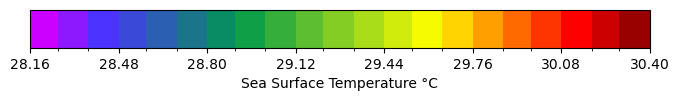

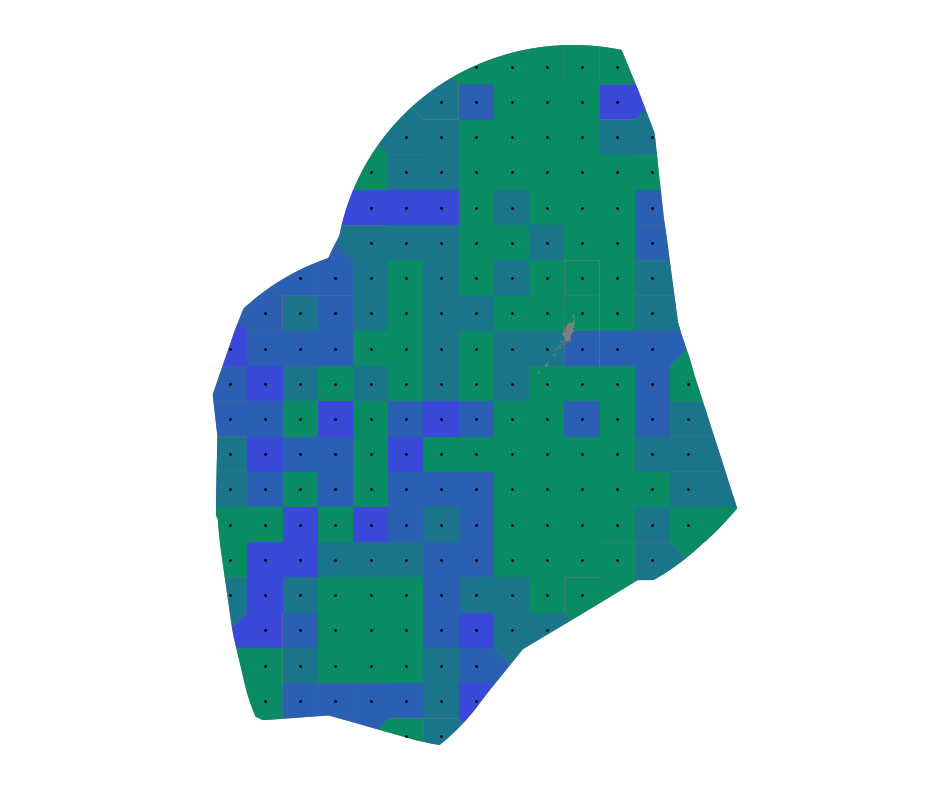

./CFS/sstgeojson/CFS1979.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


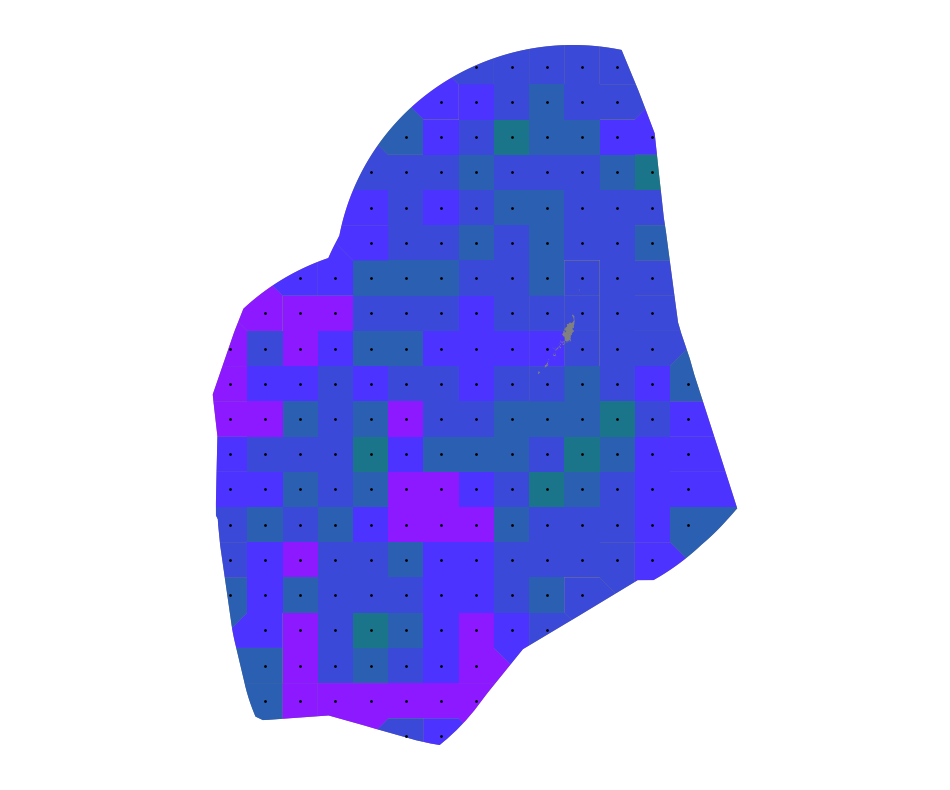

./CFS/sstgeojson/CFS1980.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


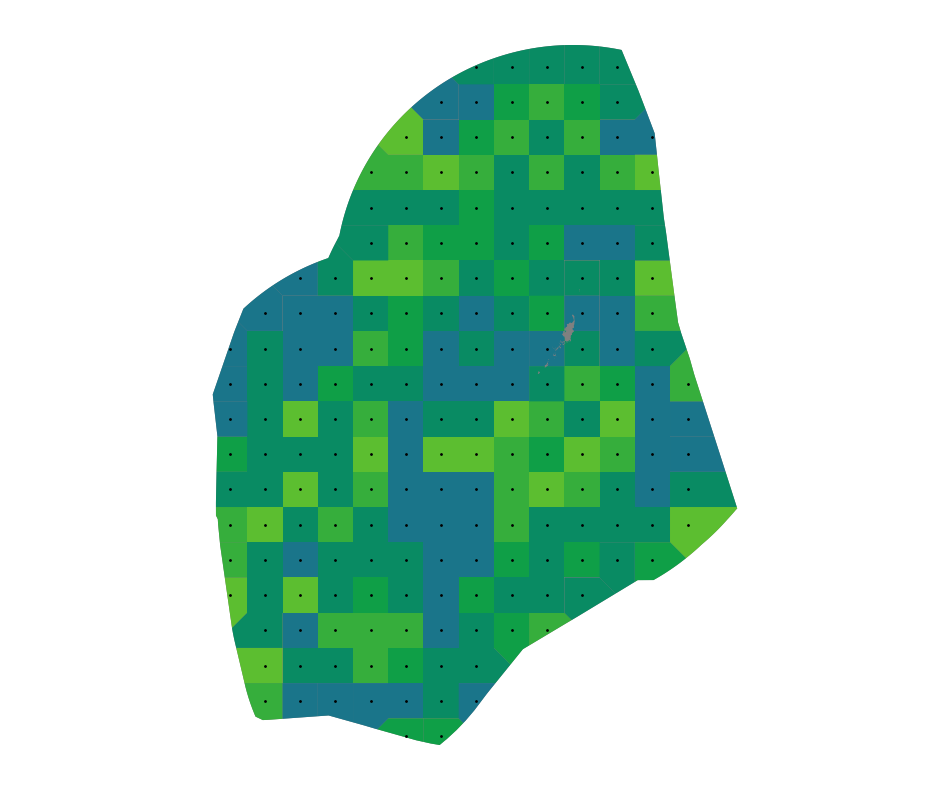

./CFS/sstgeojson/CFS1981.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


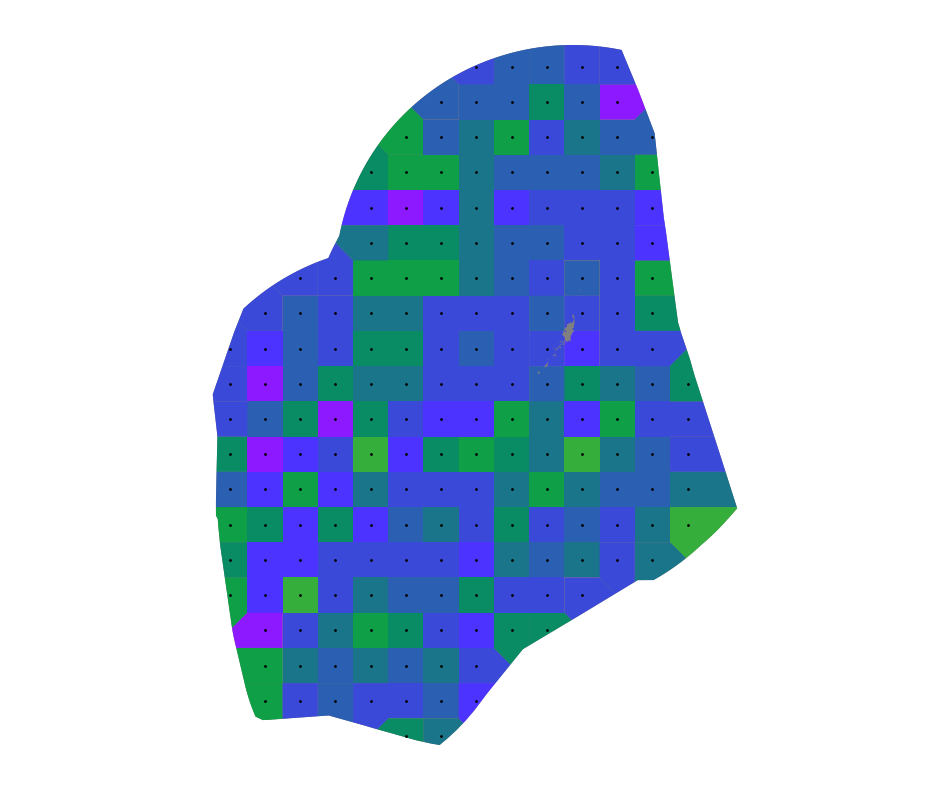

./CFS/sstgeojson/CFS1982.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


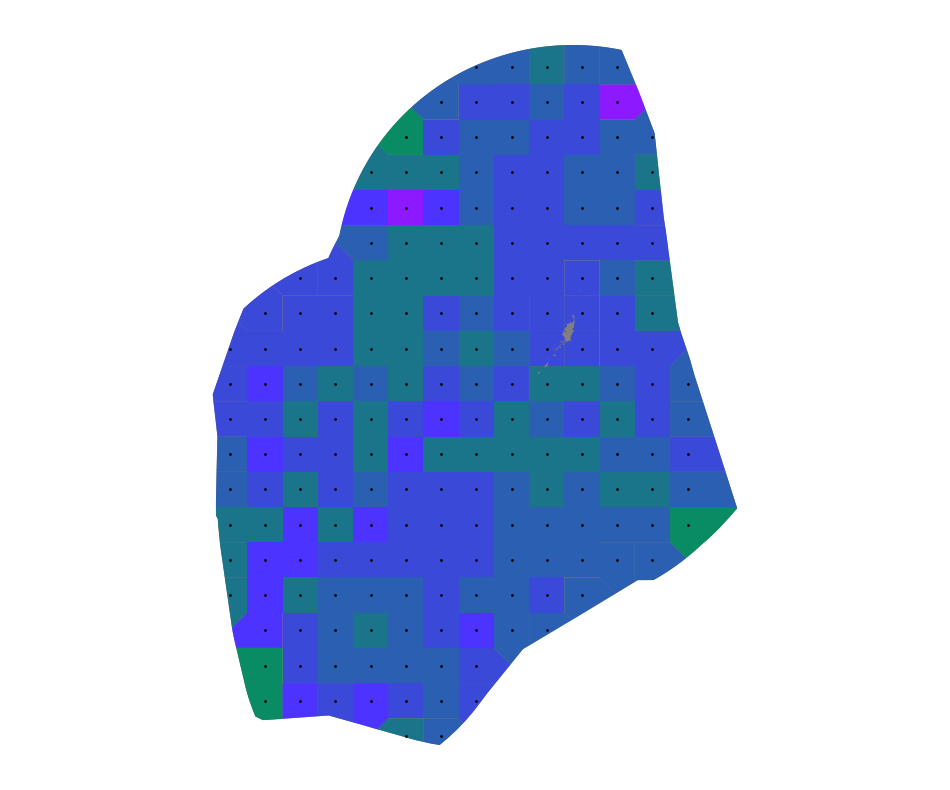

./CFS/sstgeojson/CFS1983.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


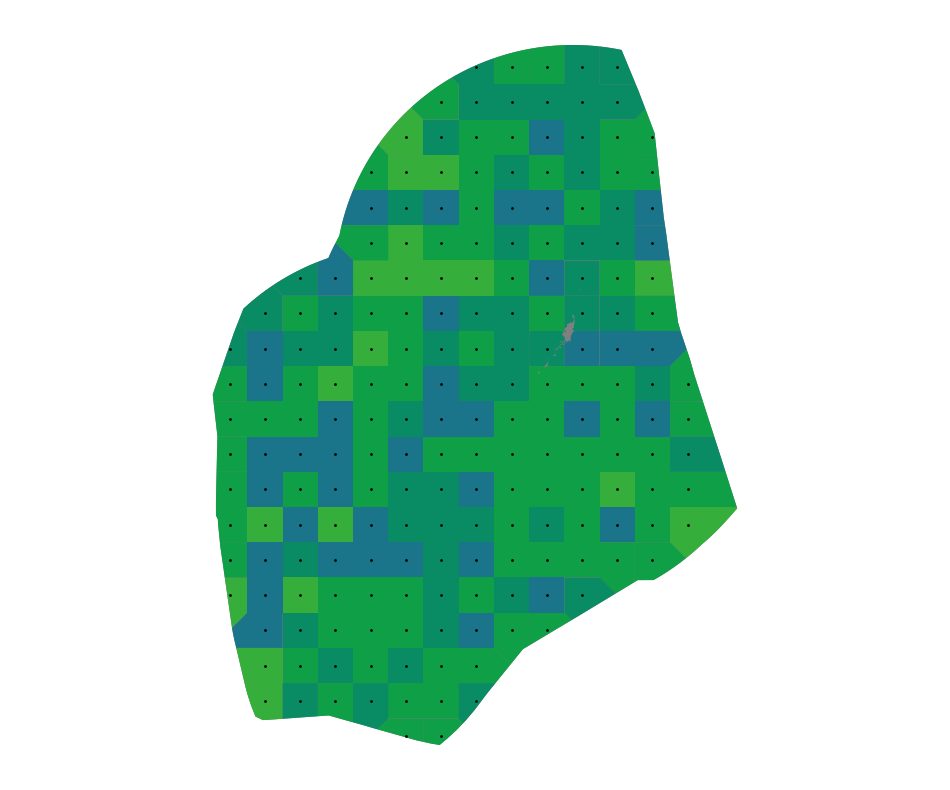

./CFS/sstgeojson/CFS1984.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


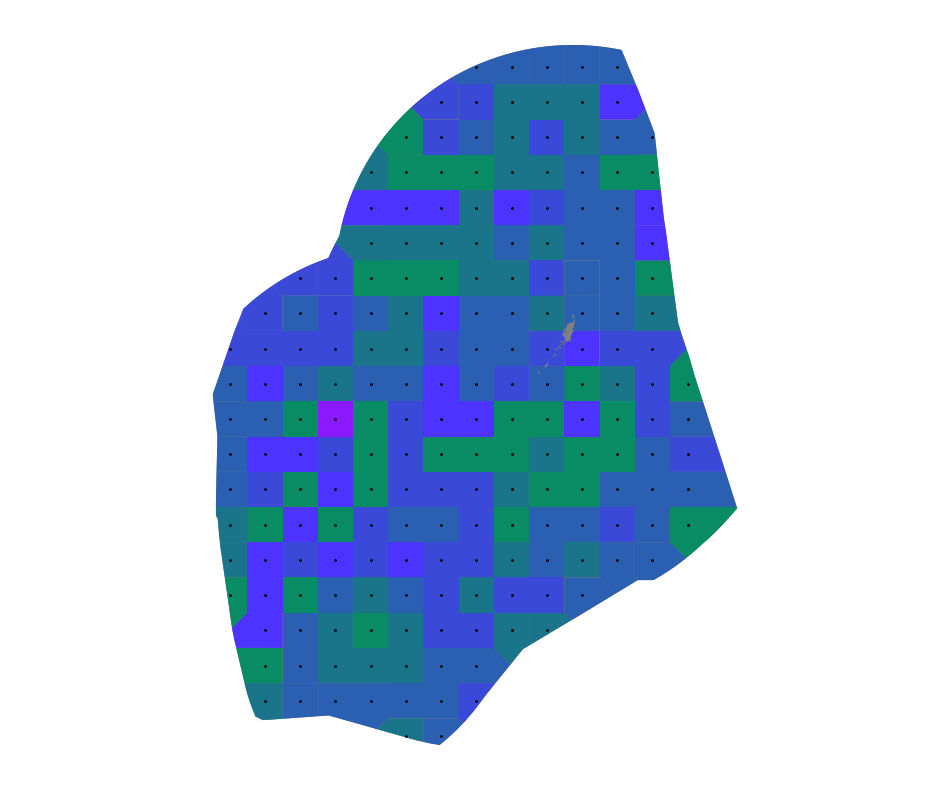

./CFS/sstgeojson/CFS1985.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


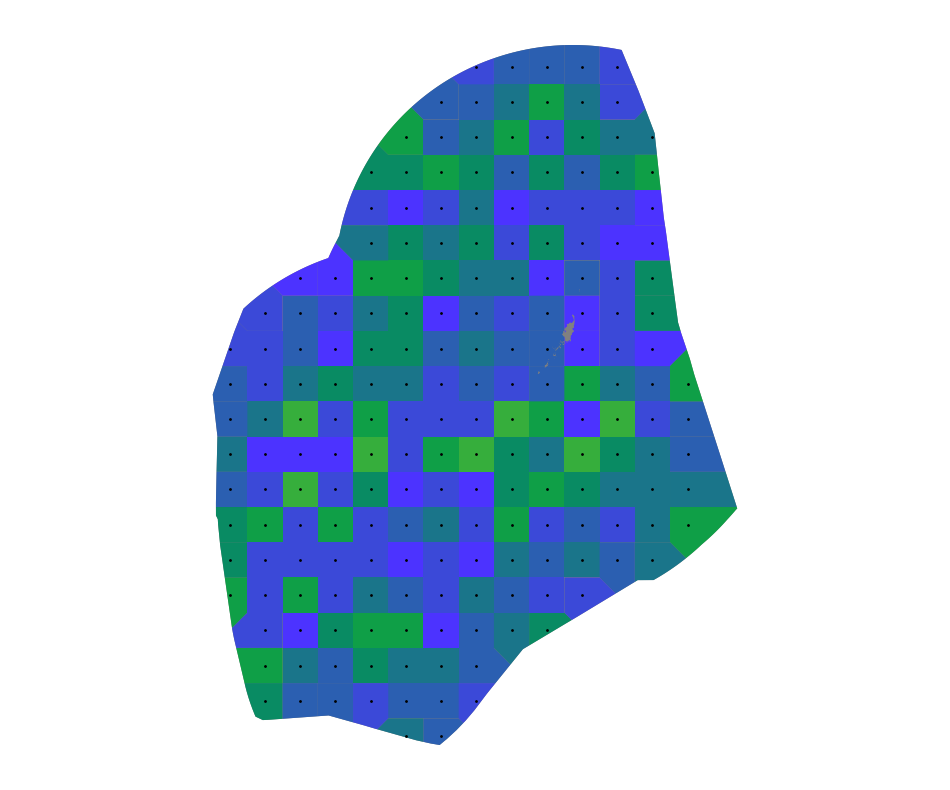

./CFS/sstgeojson/CFS1986.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


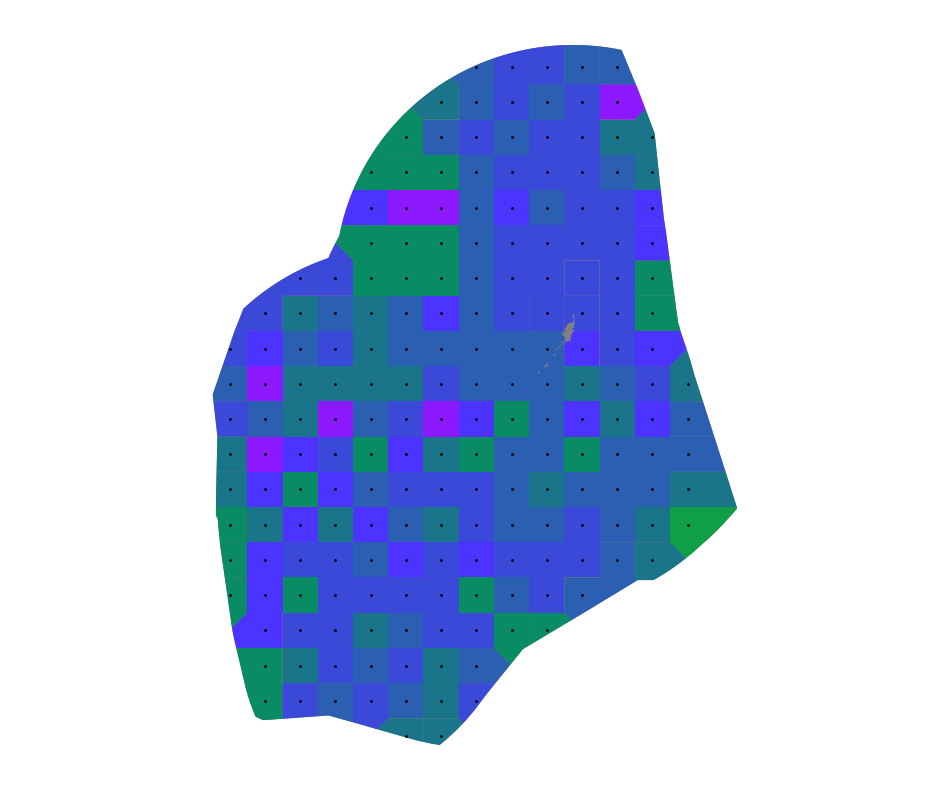

./CFS/sstgeojson/CFS1987.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


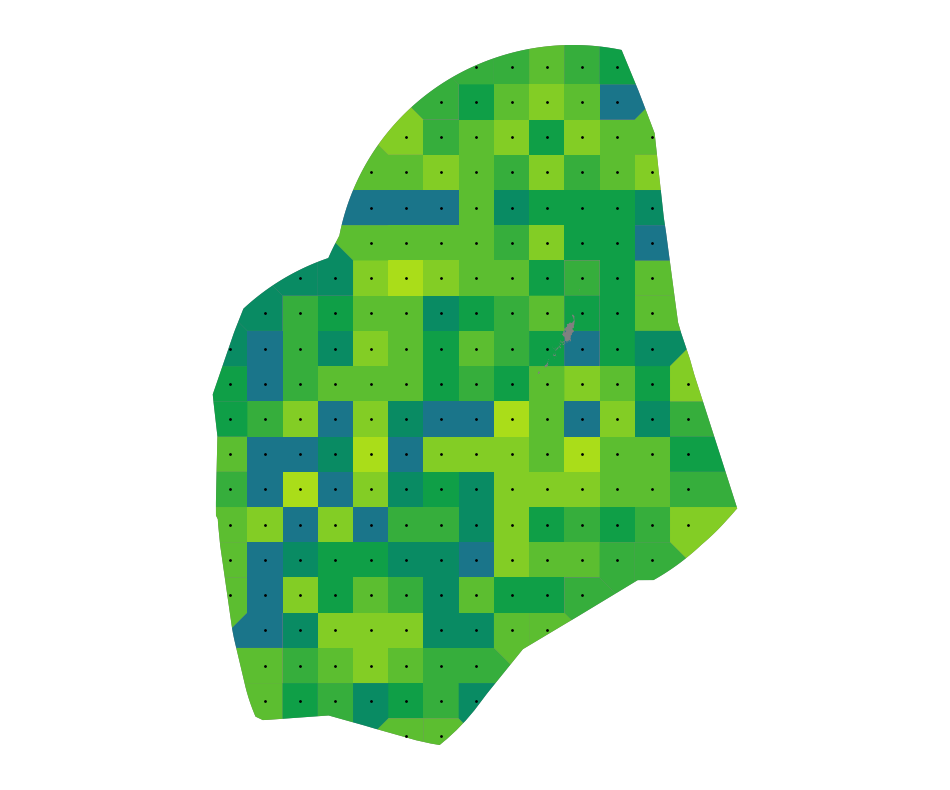

./CFS/sstgeojson/CFS1988.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


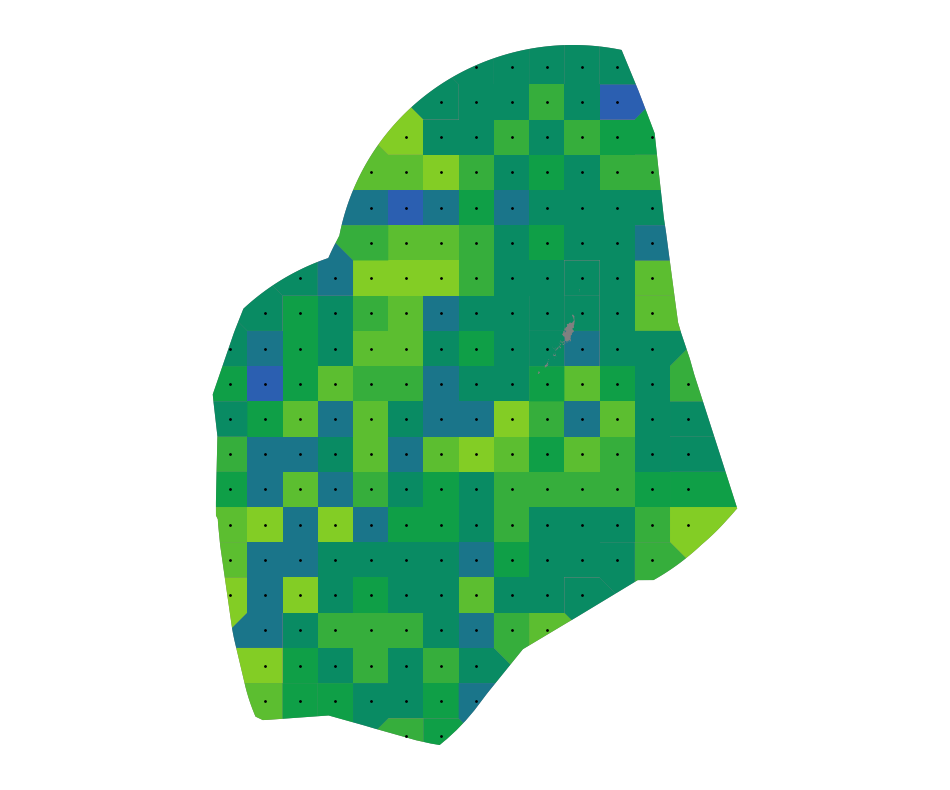

./CFS/sstgeojson/CFS1989.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


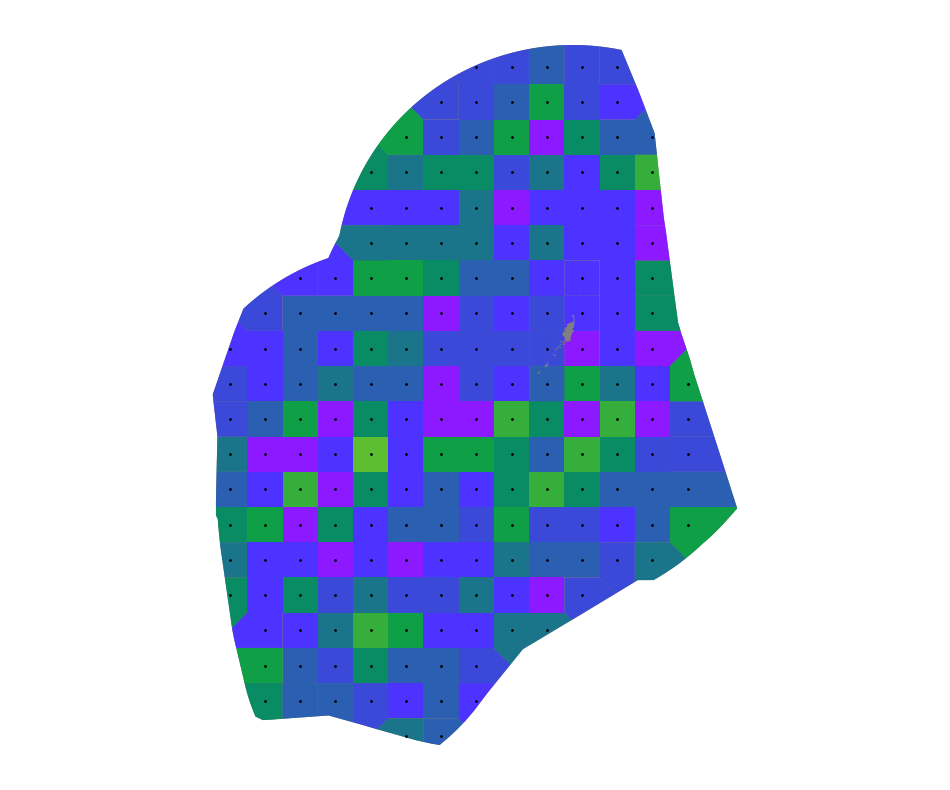

./CFS/sstgeojson/CFS1990.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


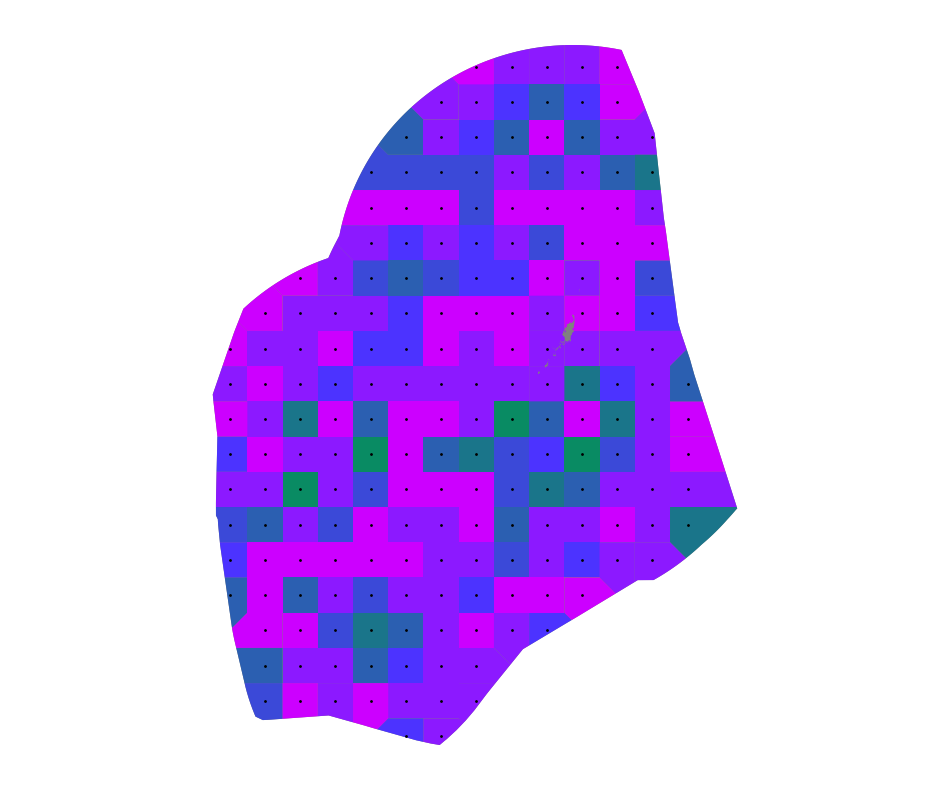

./CFS/sstgeojson/CFS1991.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


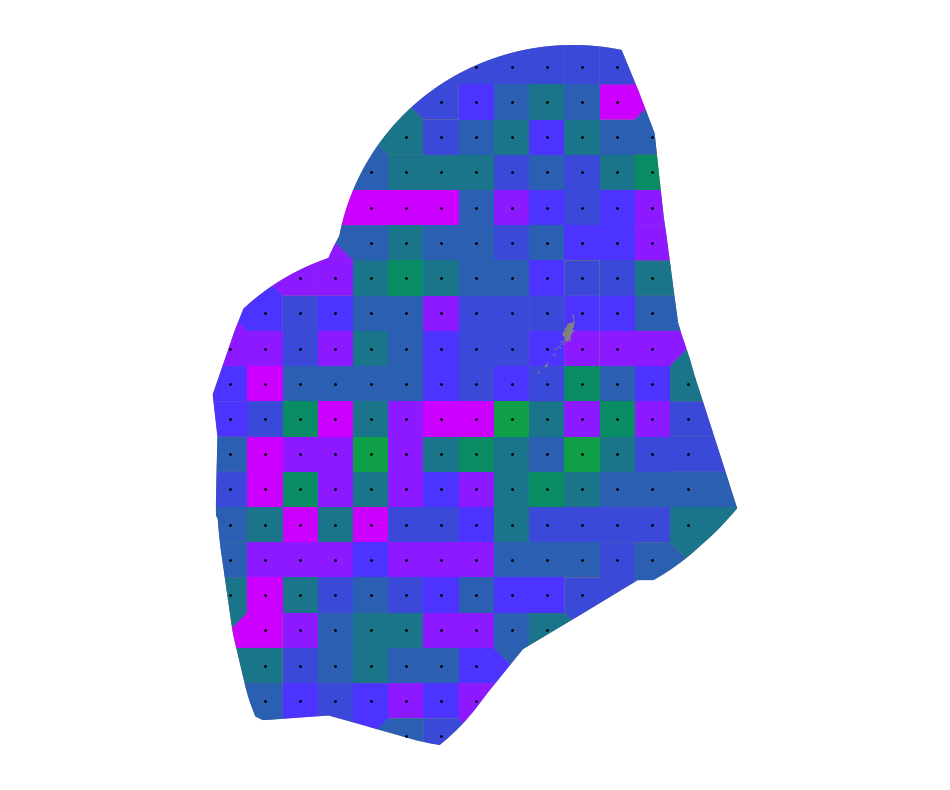

./CFS/sstgeojson/CFS1992.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


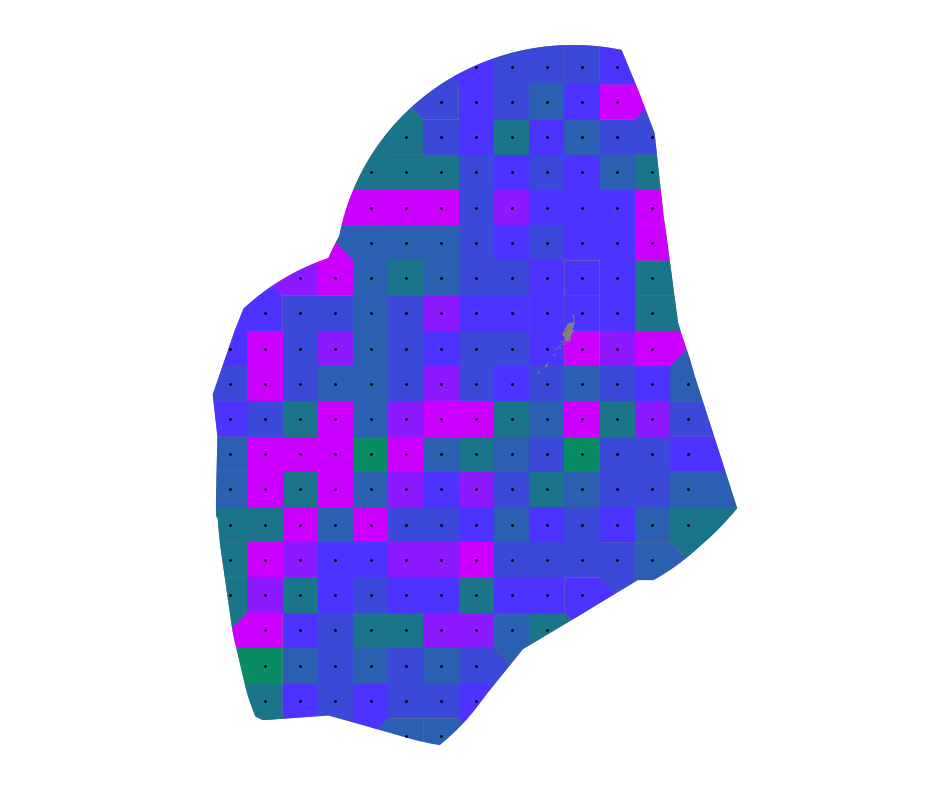

./CFS/sstgeojson/CFS1993.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


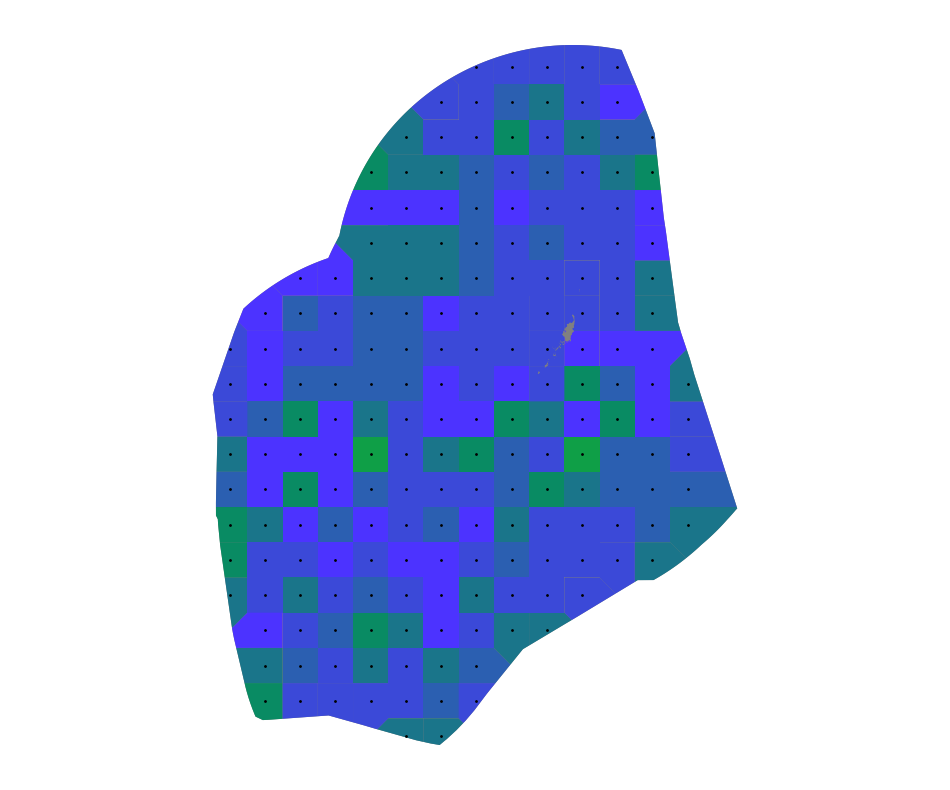

./CFS/sstgeojson/CFS1994.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


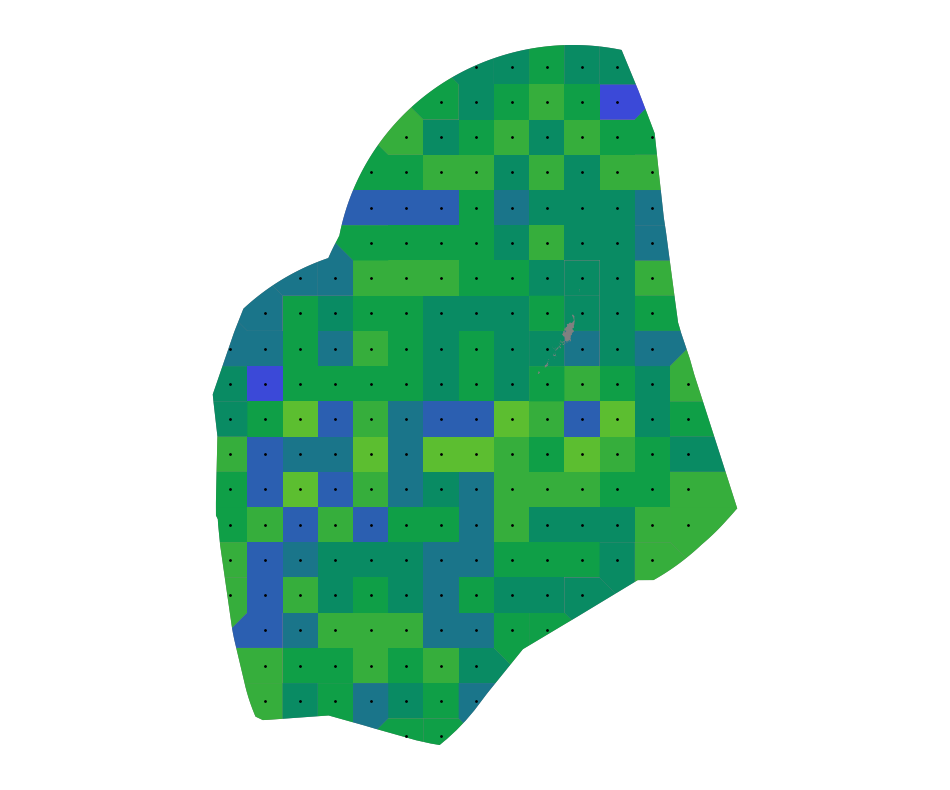

./CFS/sstgeojson/CFS1995.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


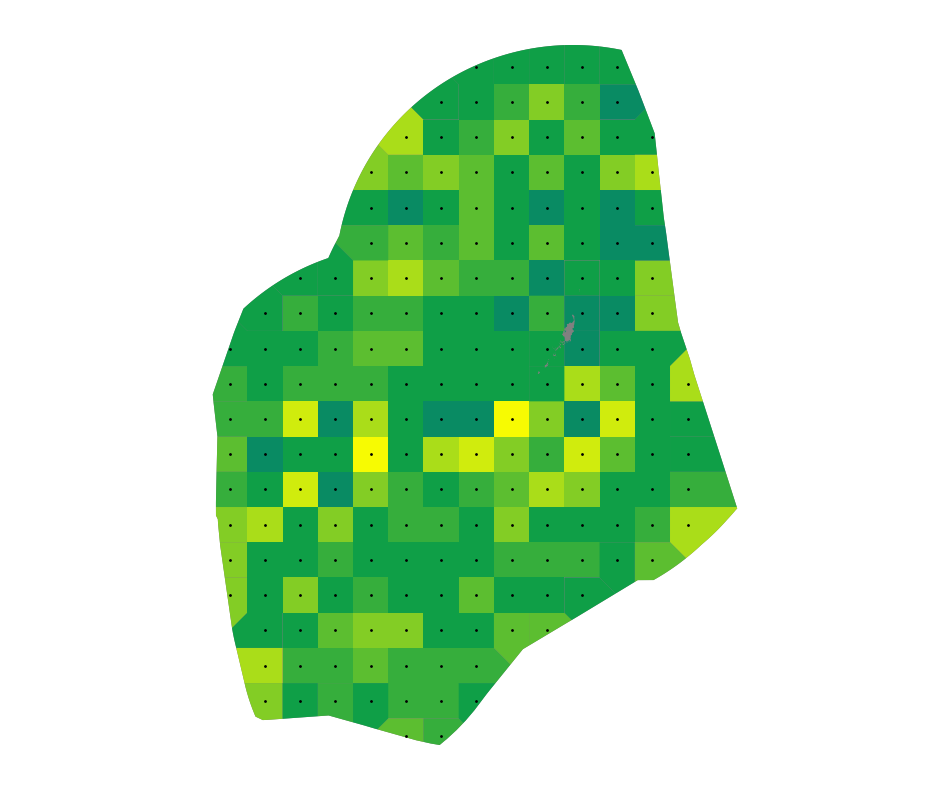

./CFS/sstgeojson/CFS1996.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


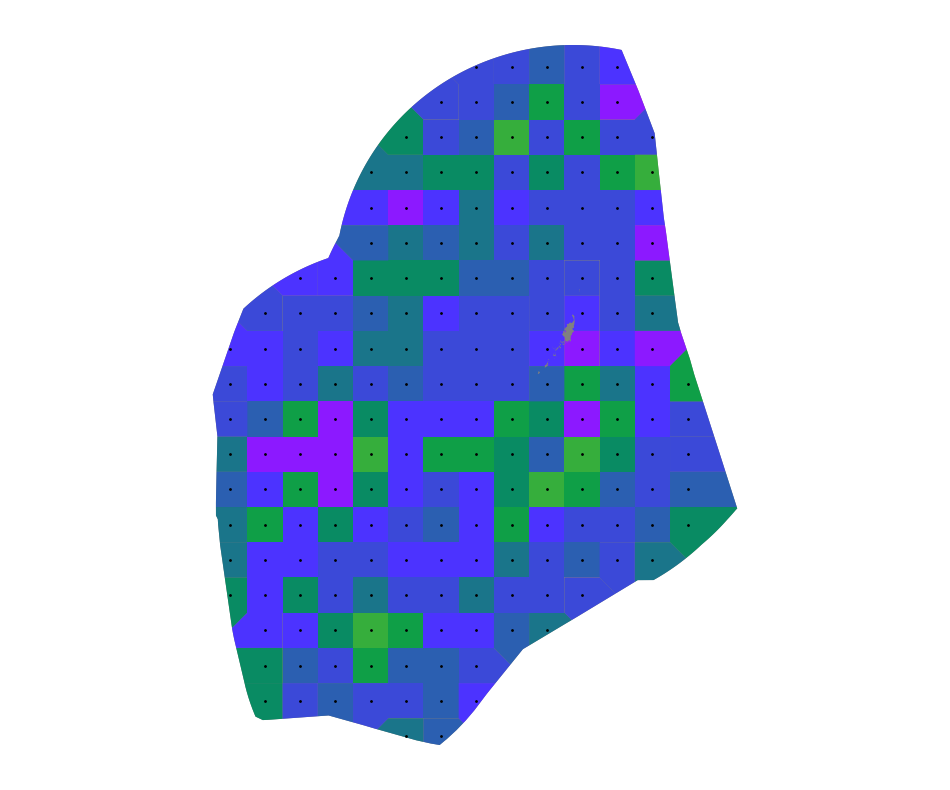

./CFS/sstgeojson/CFS1997.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


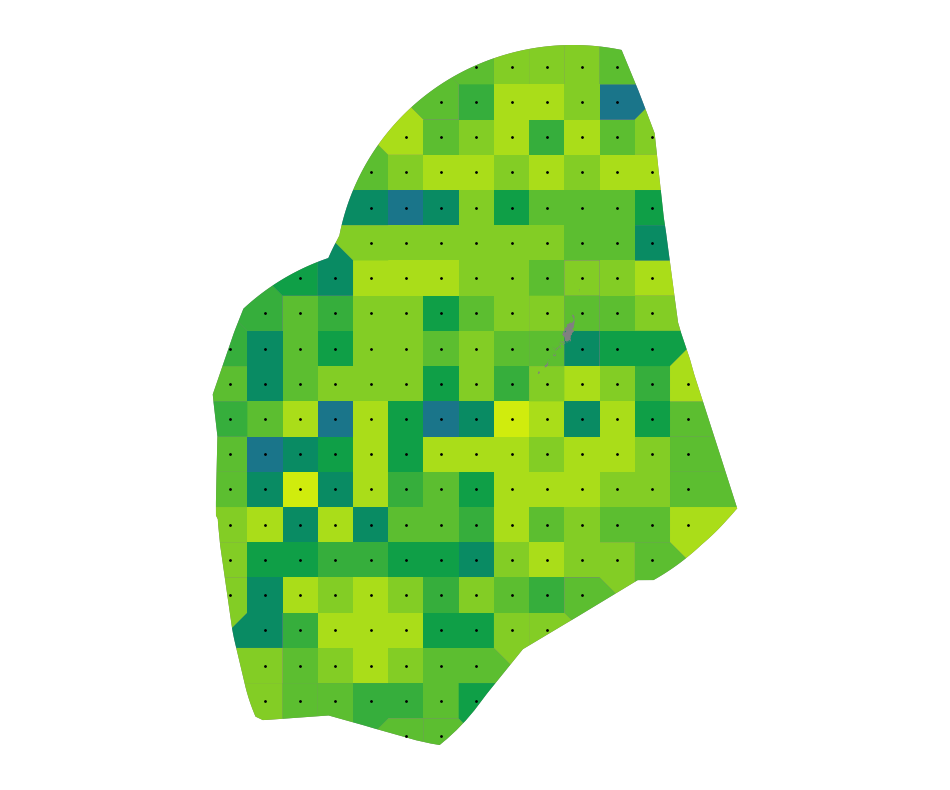

./CFS/sstgeojson/CFS1998.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


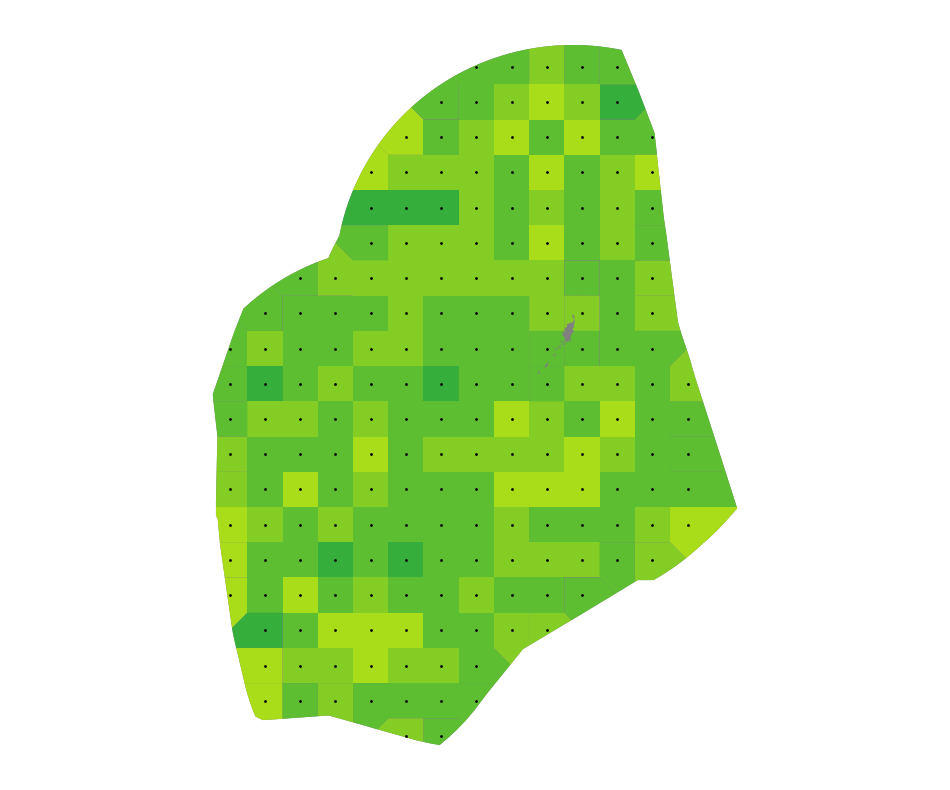

./CFS/sstgeojson/CFS1999.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


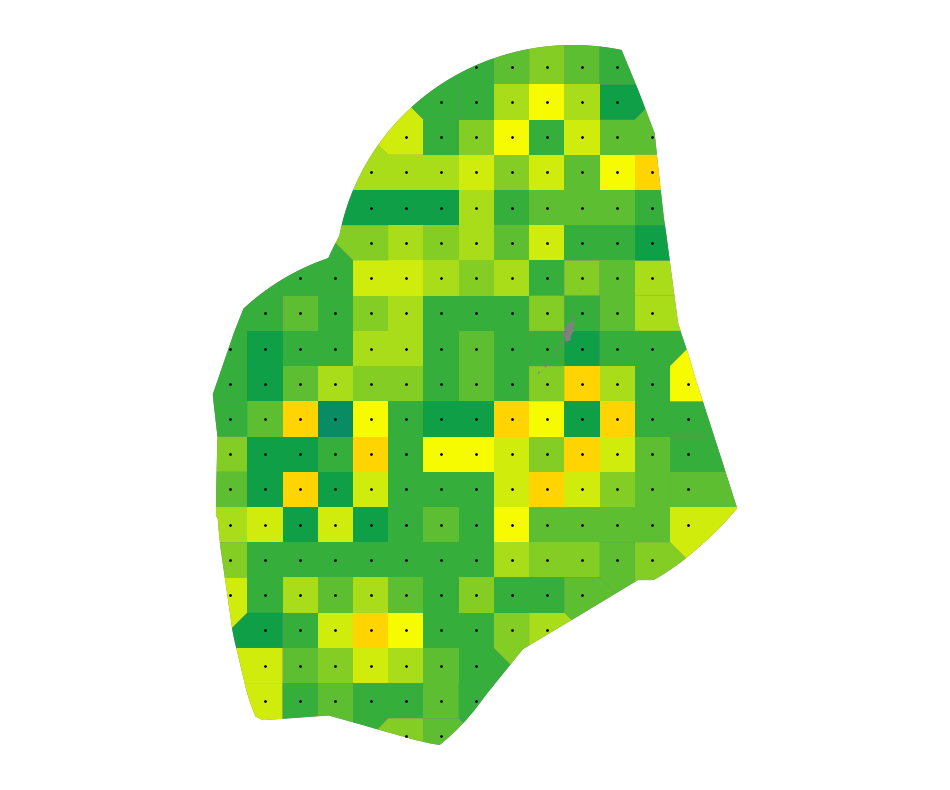

./CFS/sstgeojson/CFS2000.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


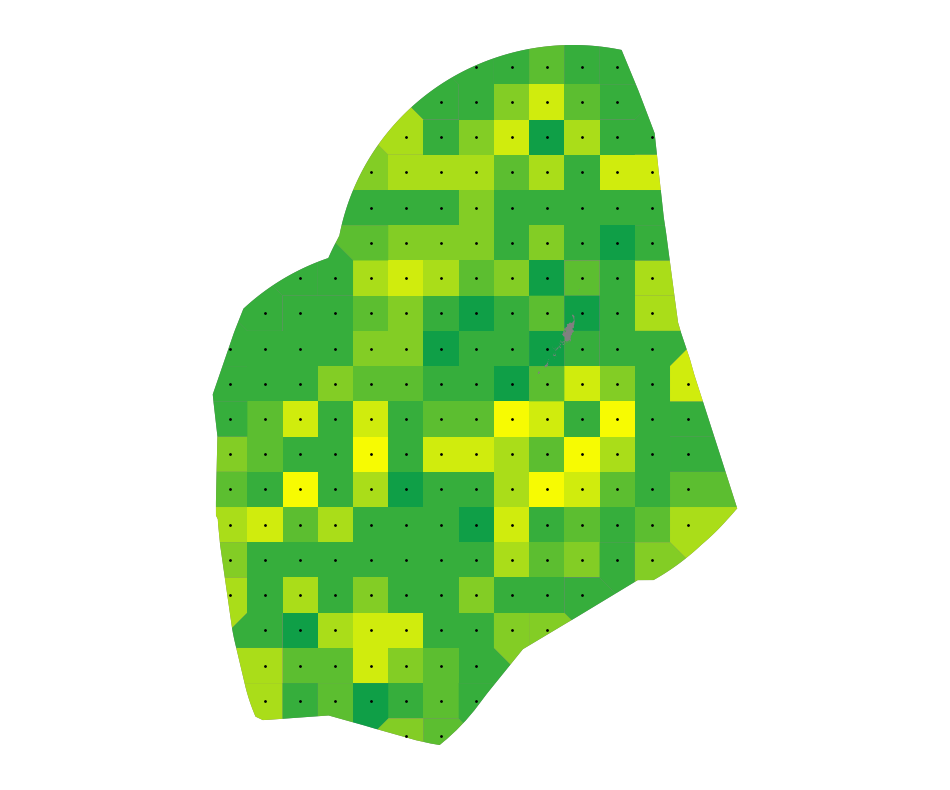

./CFS/sstgeojson/CFS2001.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


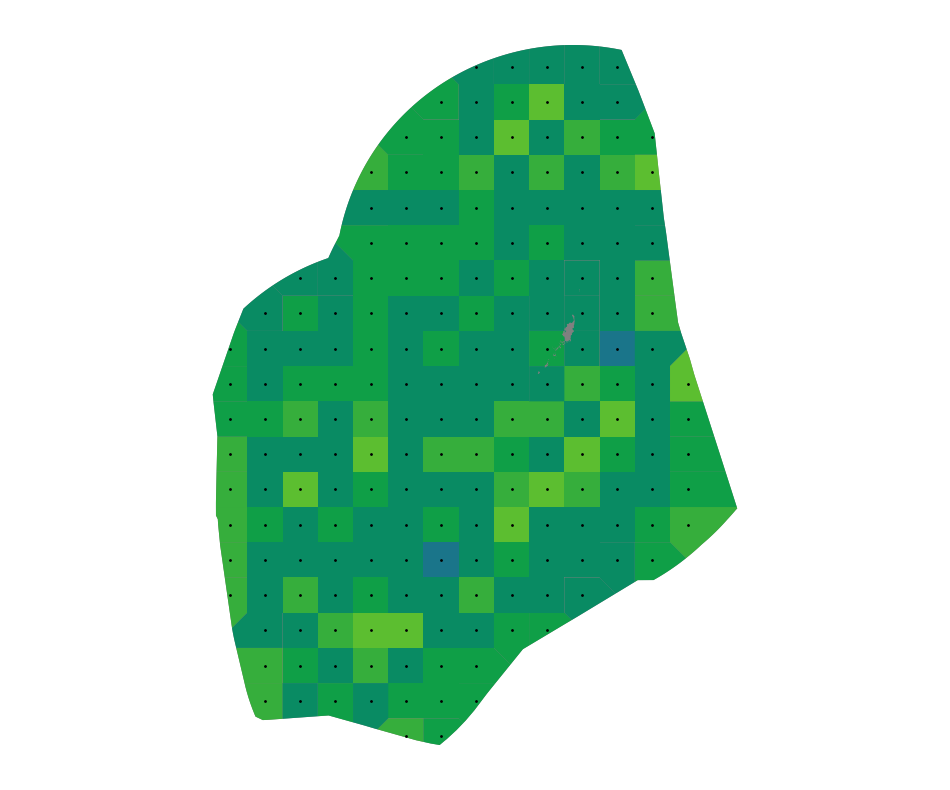

./CFS/sstgeojson/CFS2002.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


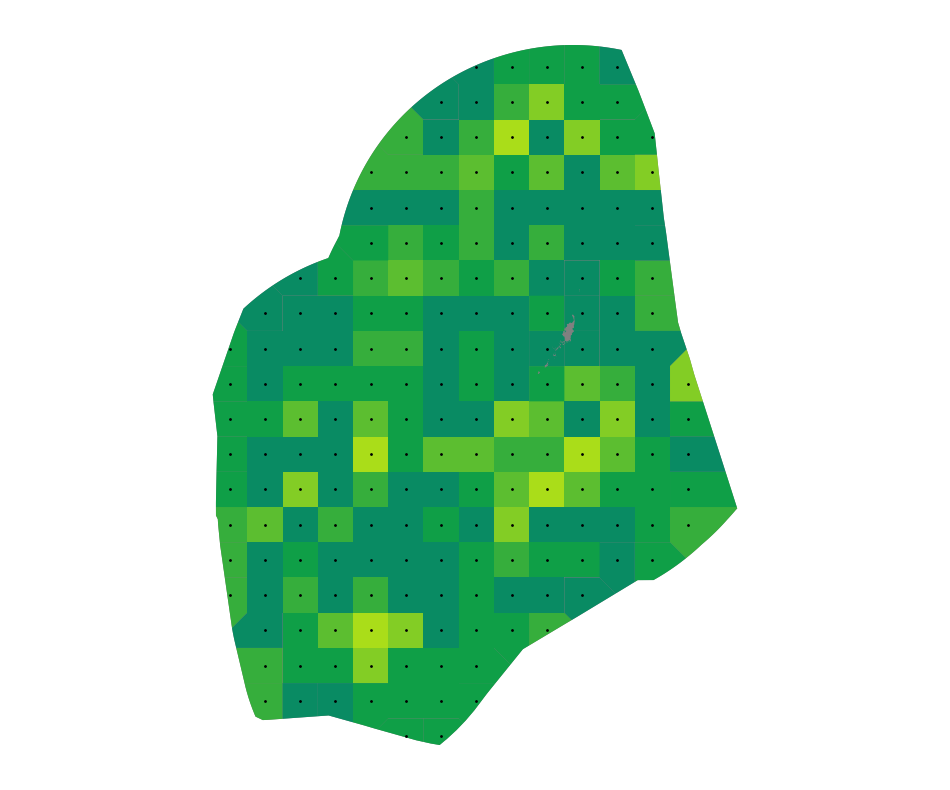

./CFS/sstgeojson/CFS2003.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


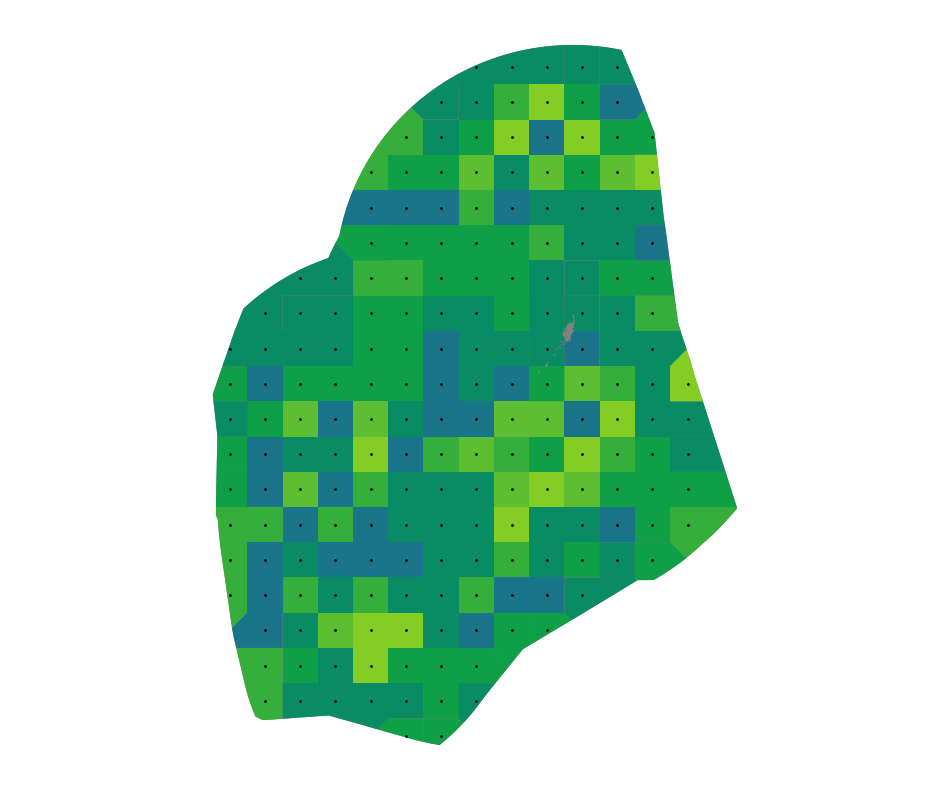

./CFS/sstgeojson/CFS2004.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


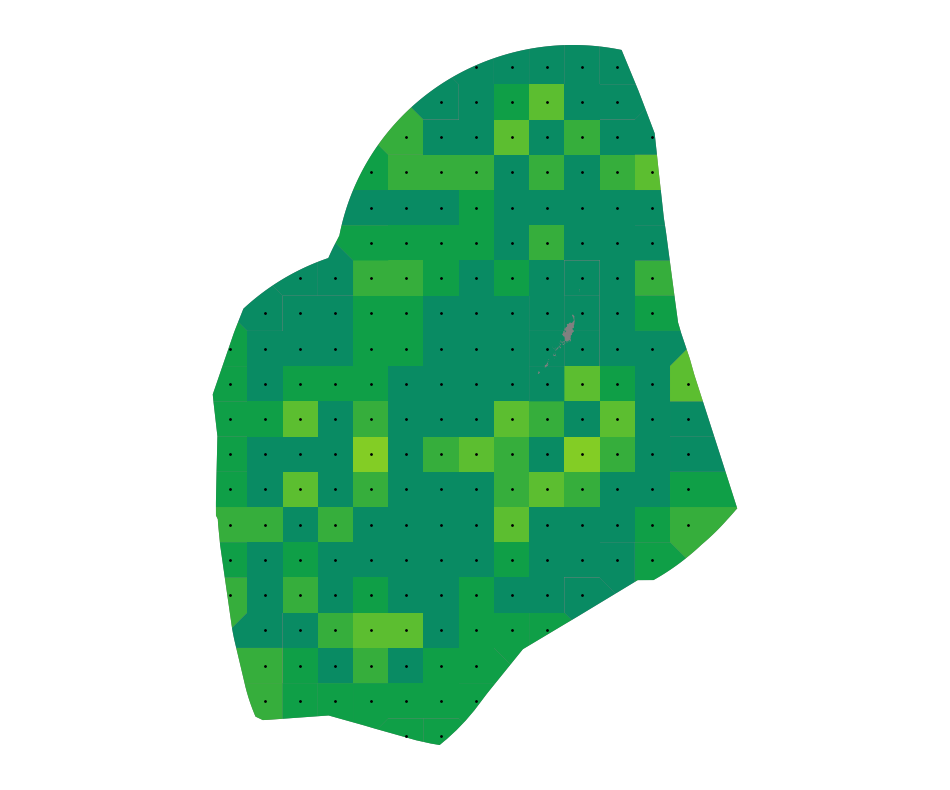

./CFS/sstgeojson/CFS2005.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


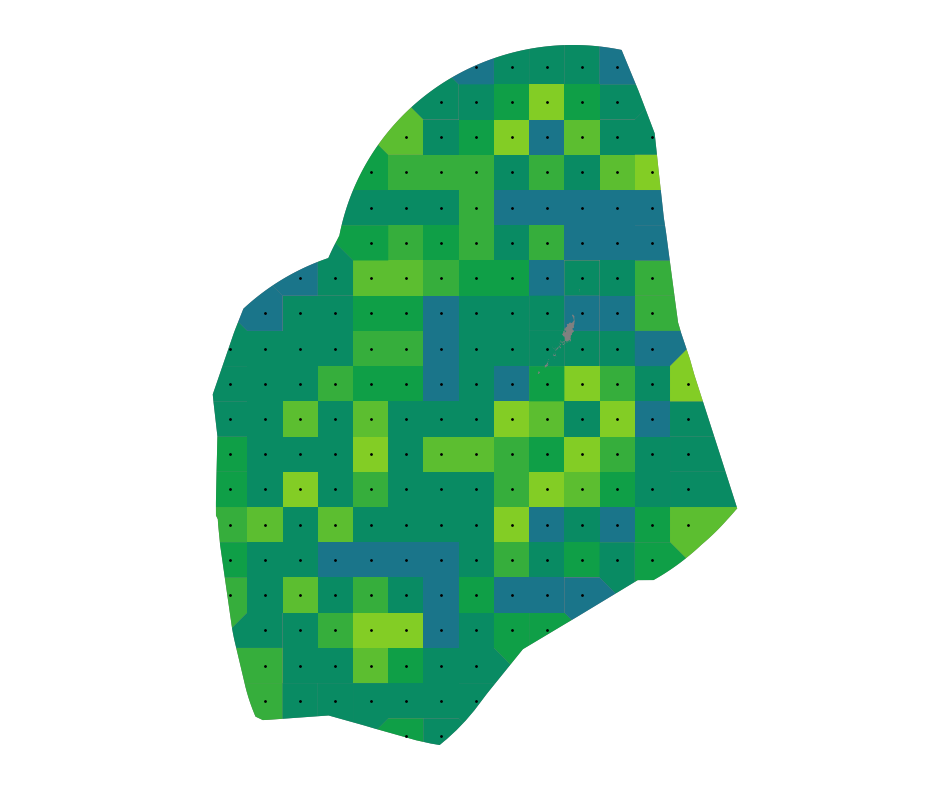

./CFS/sstgeojson/CFS2006.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


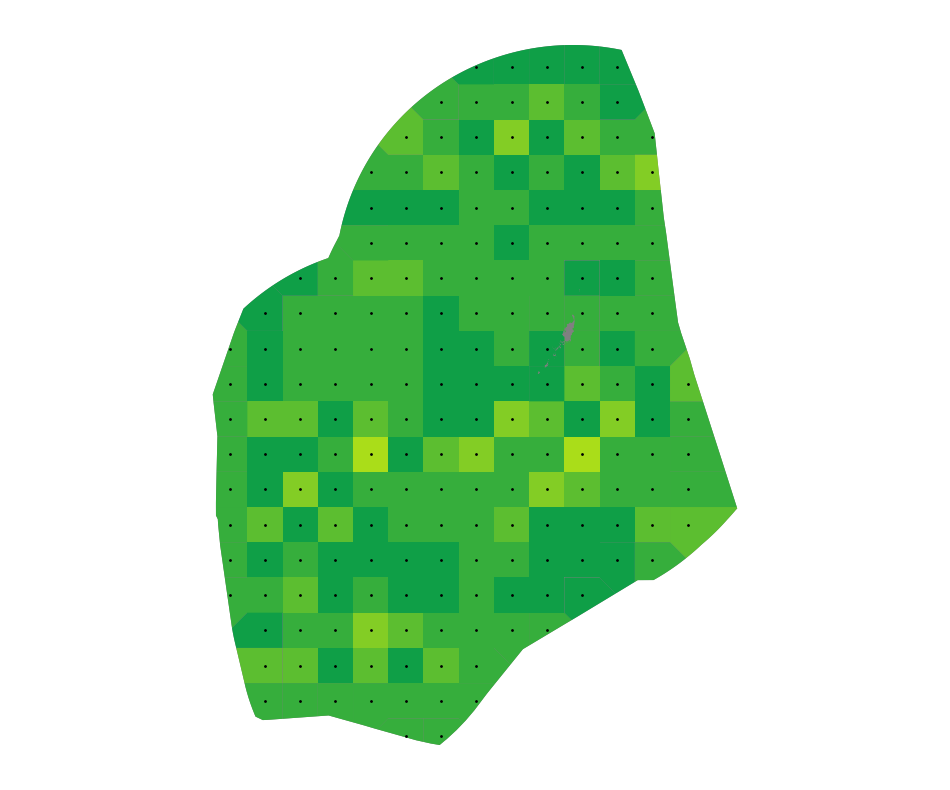

./CFS/sstgeojson/CFS2007.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


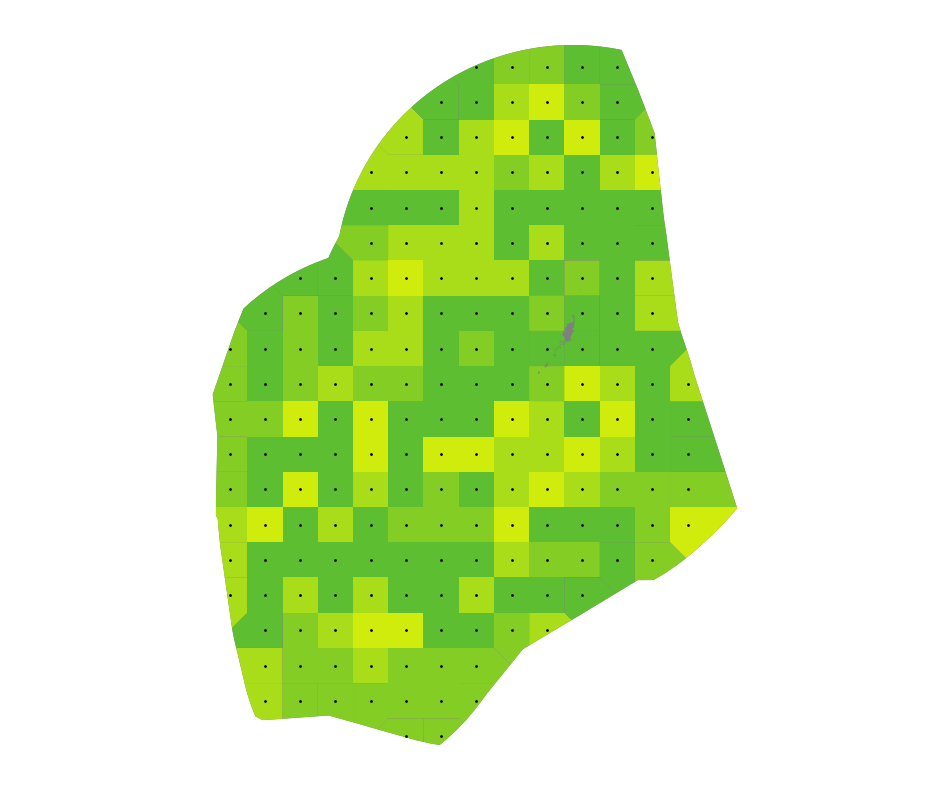

./CFS/sstgeojson/CFS2008.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


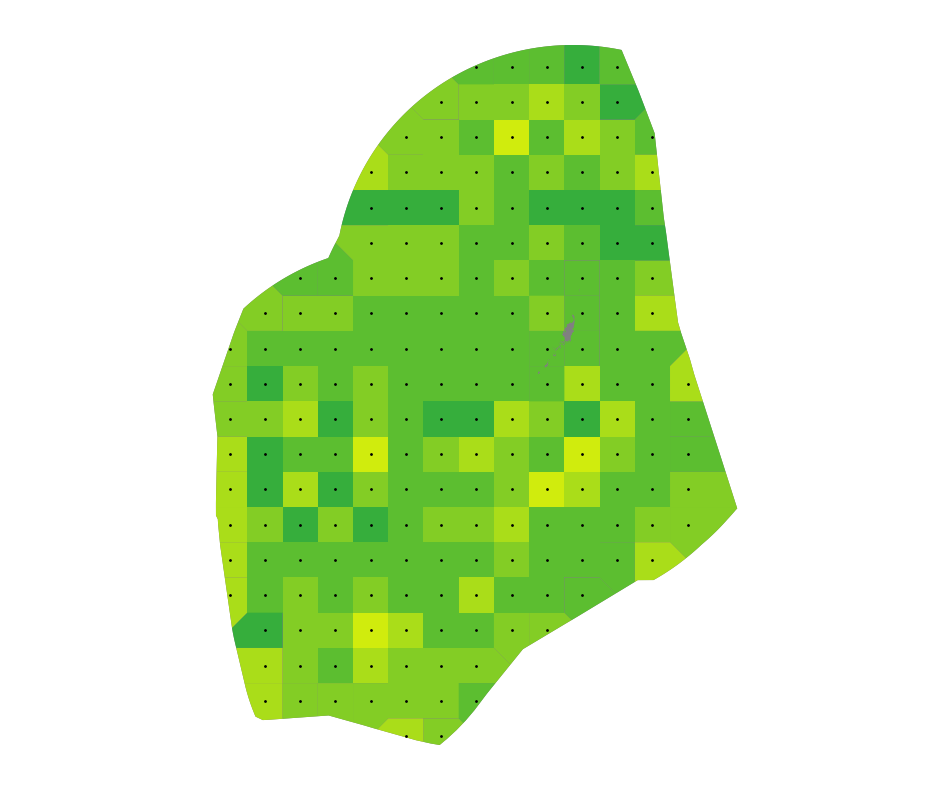

./CFS/sstgeojson/CFS2009.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


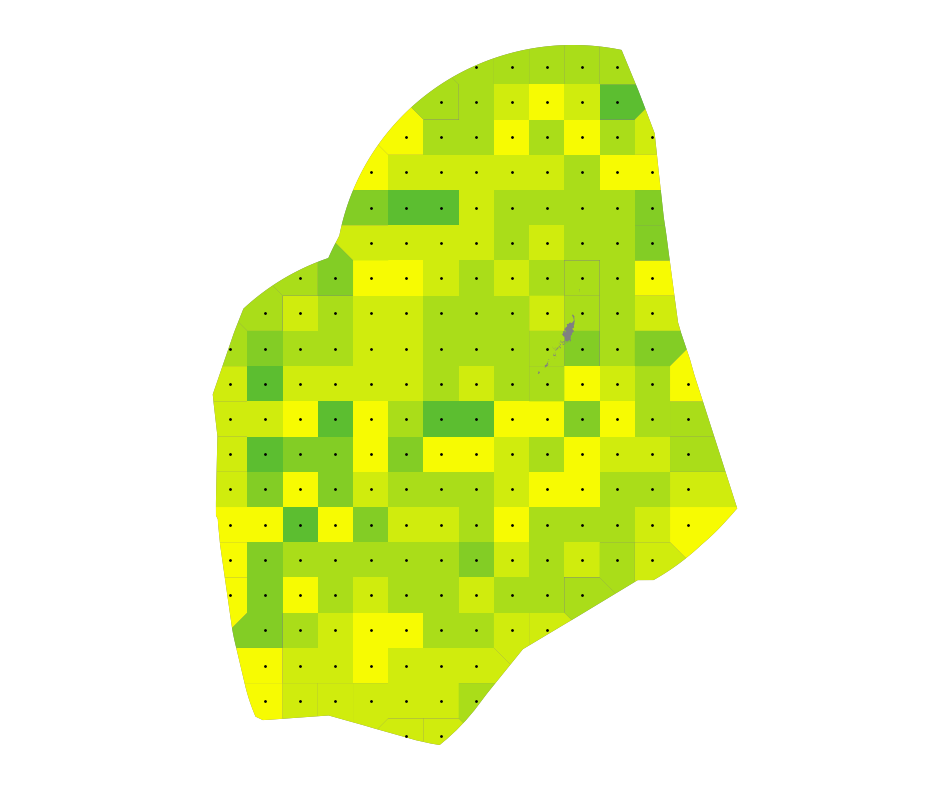

./CFS/sstgeojson/CFS2010.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


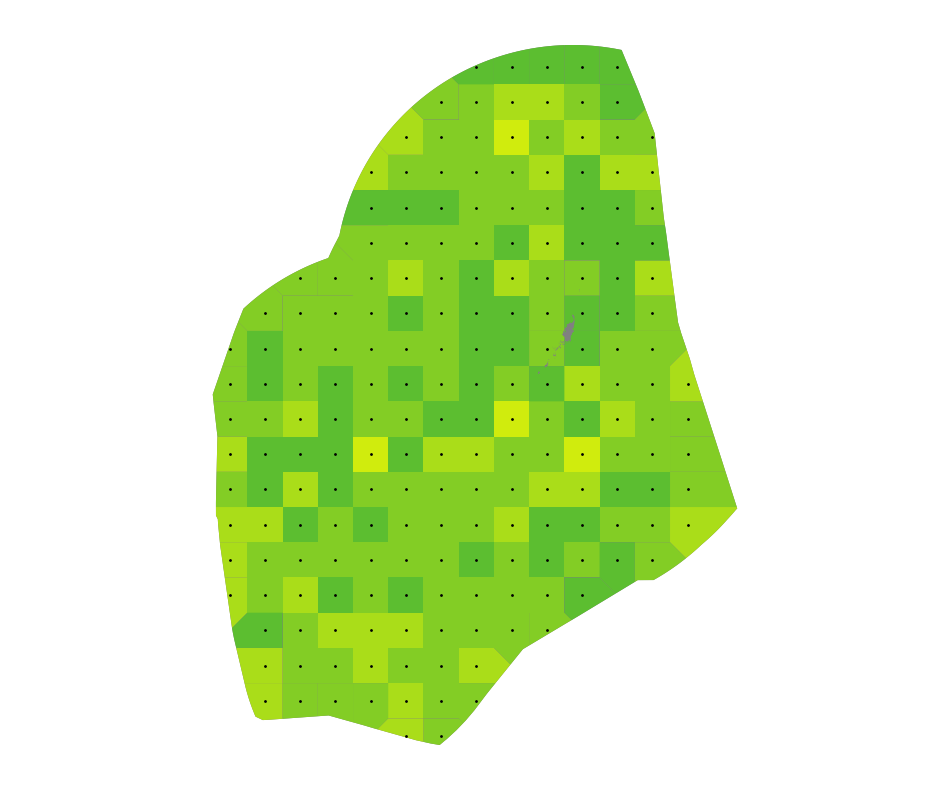

./CFS/sstgeojson/CFS2011.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


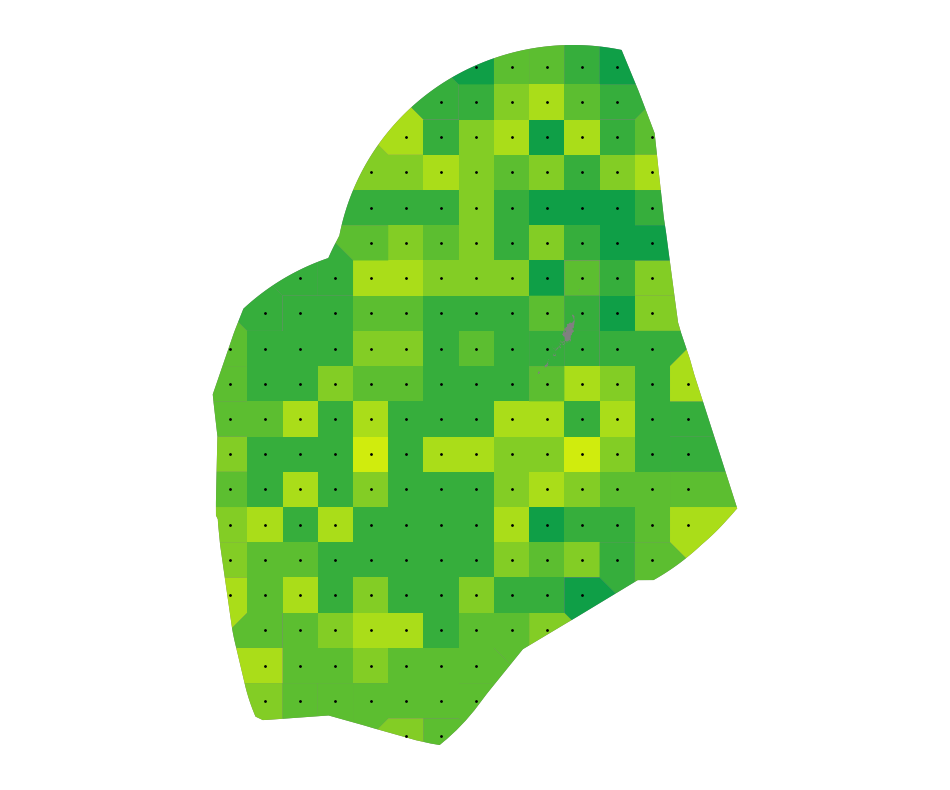

./CFS/sstgeojson/CFS2012.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


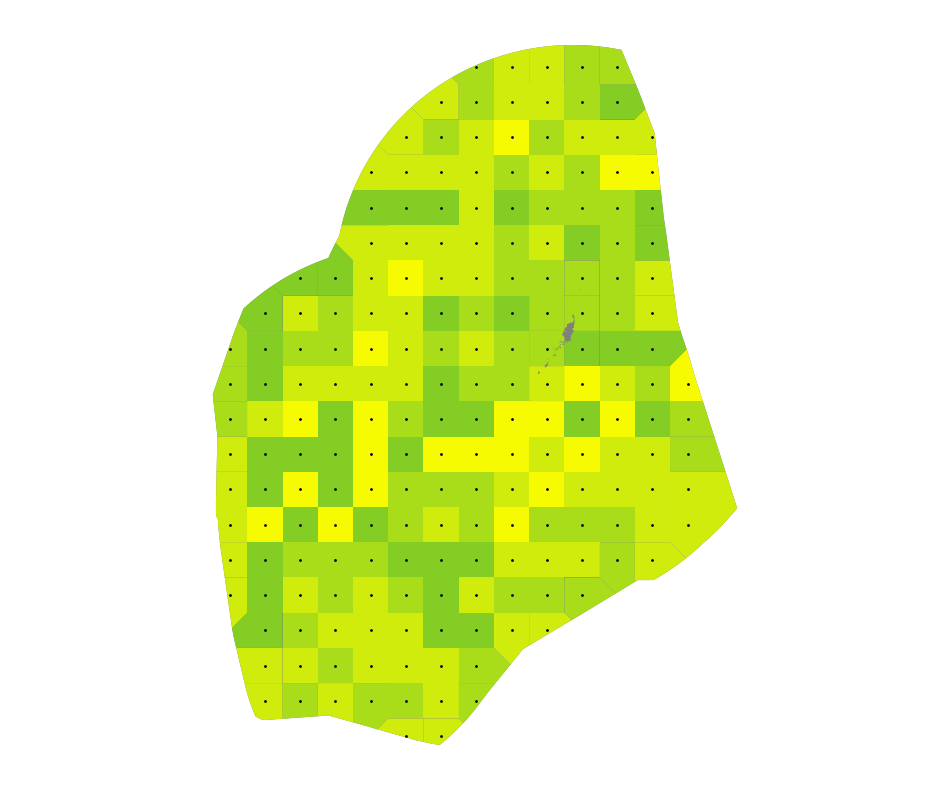

./CFS/sstgeojson/CFS2013.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


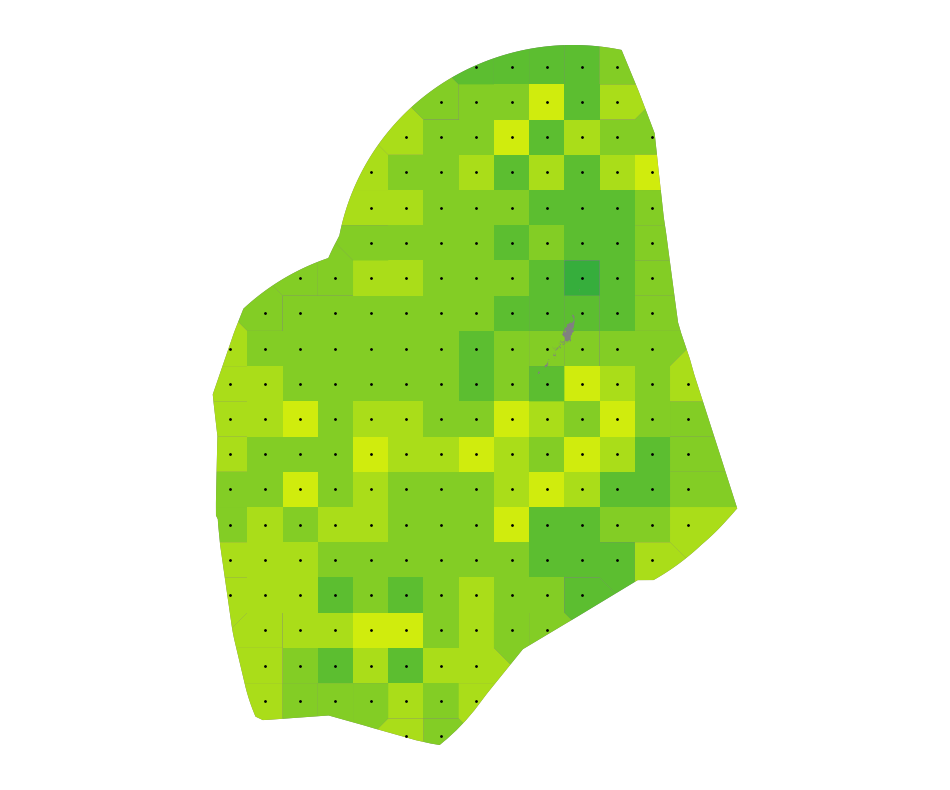

./CFS/sstgeojson/CFS2014.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


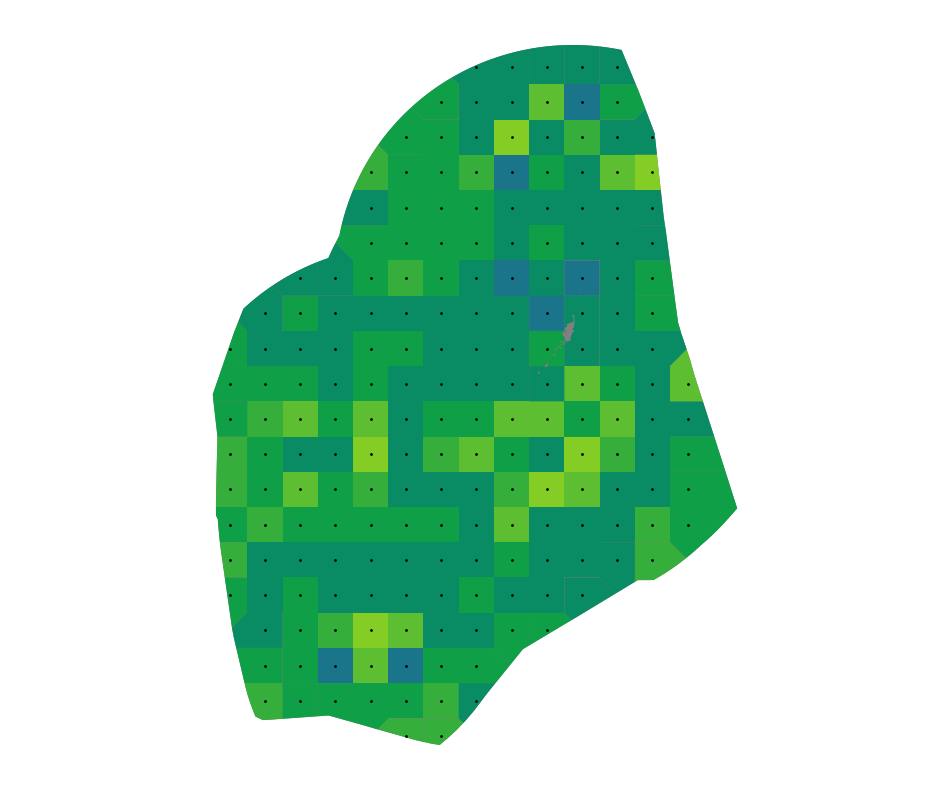

./CFS/sstgeojson/CFS2015.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


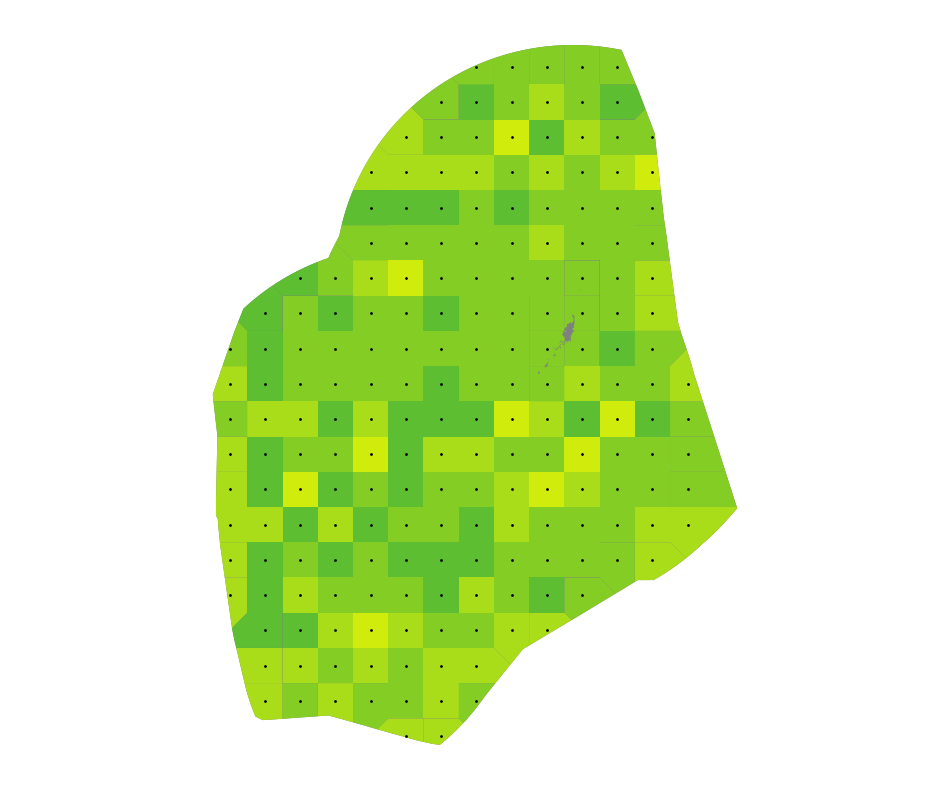

./CFS/sstgeojson/CFS2016.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


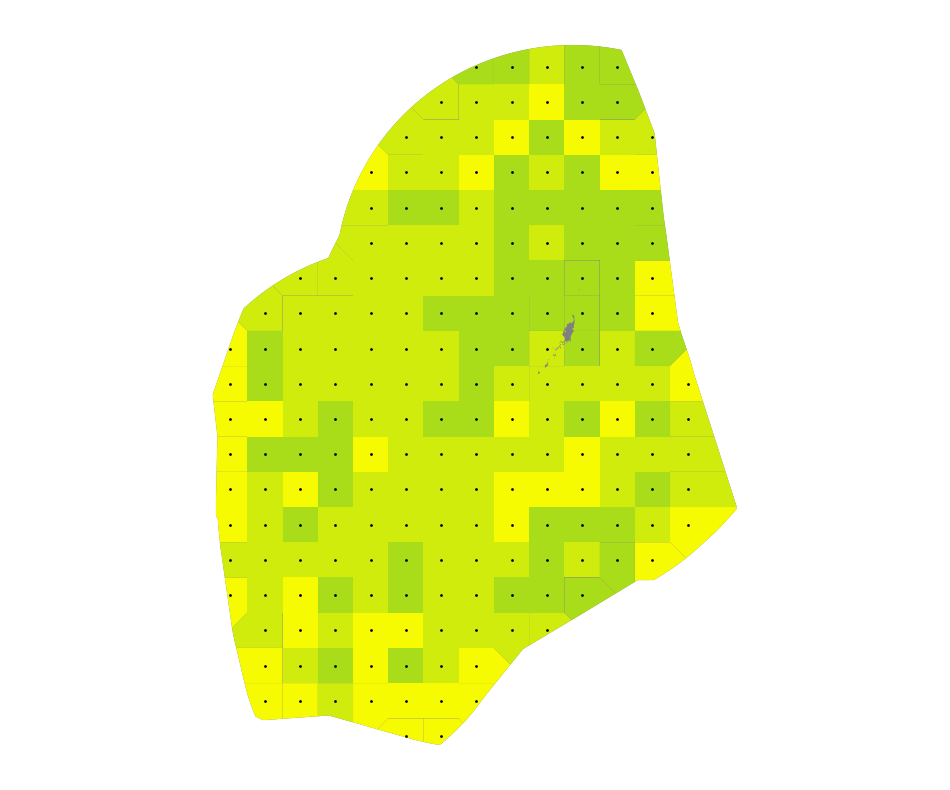

./CFS/sstgeojson/CFS2017.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


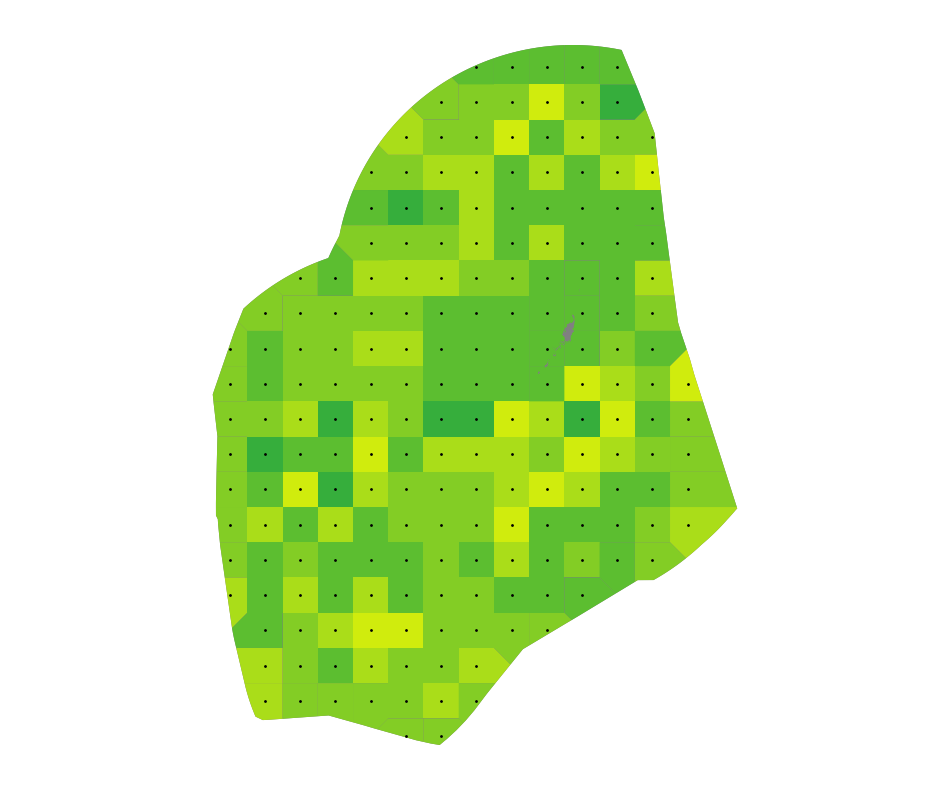

./CFS/sstgeojson/CFS2018.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


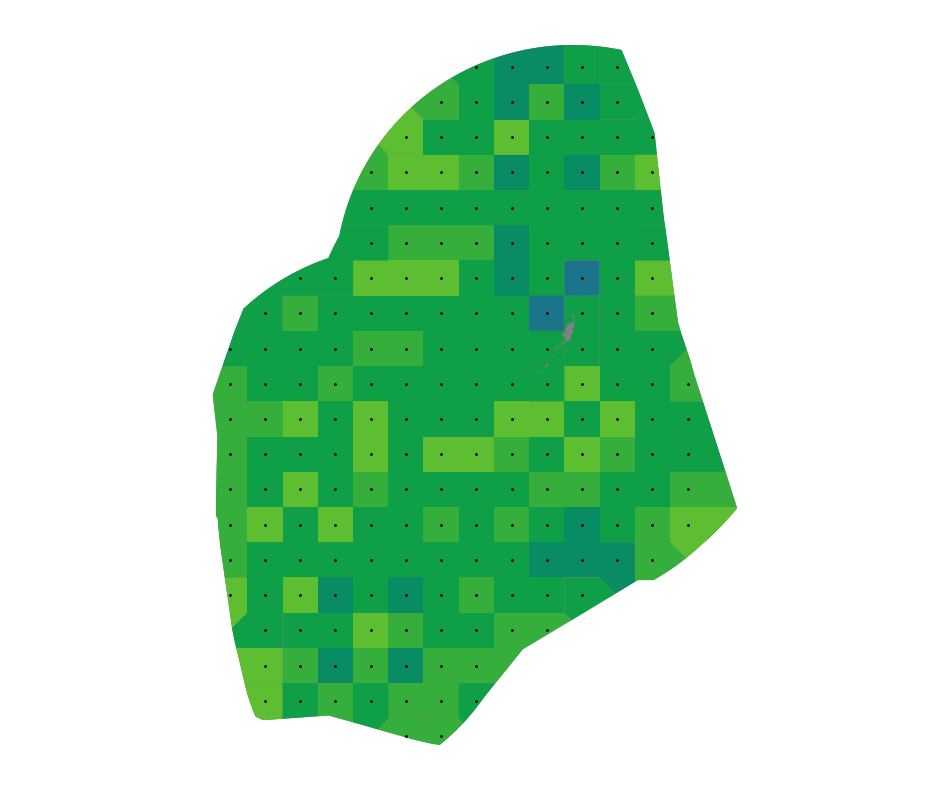

./CFS/sstgeojson/CFS2019.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


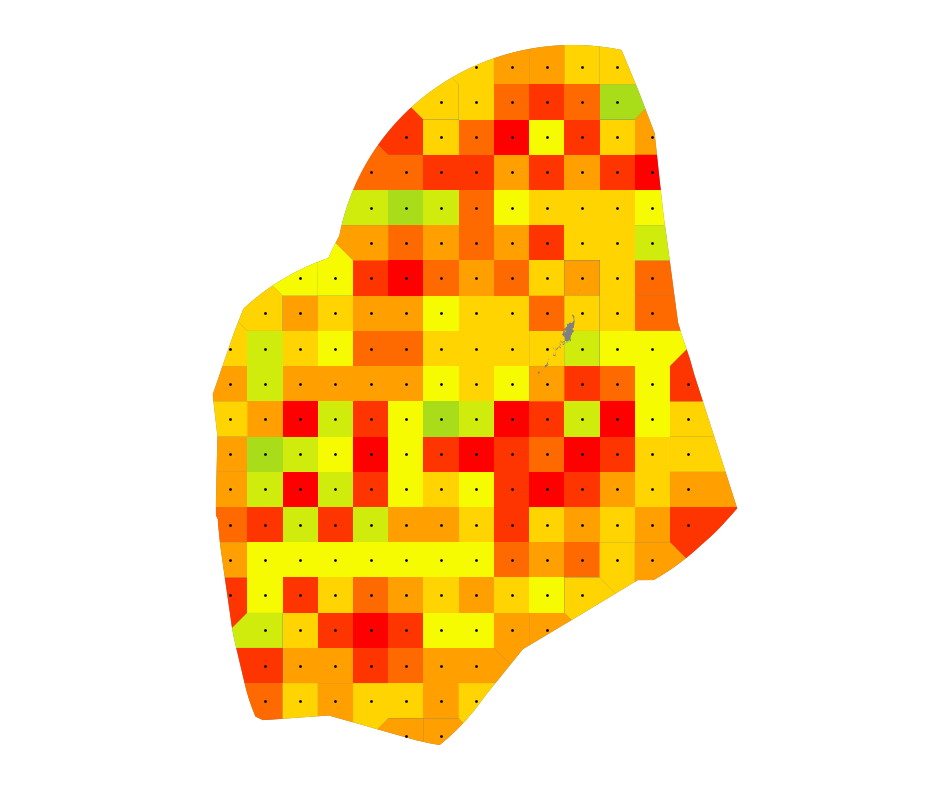

./CFS/sstgeojson/CFS2020.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


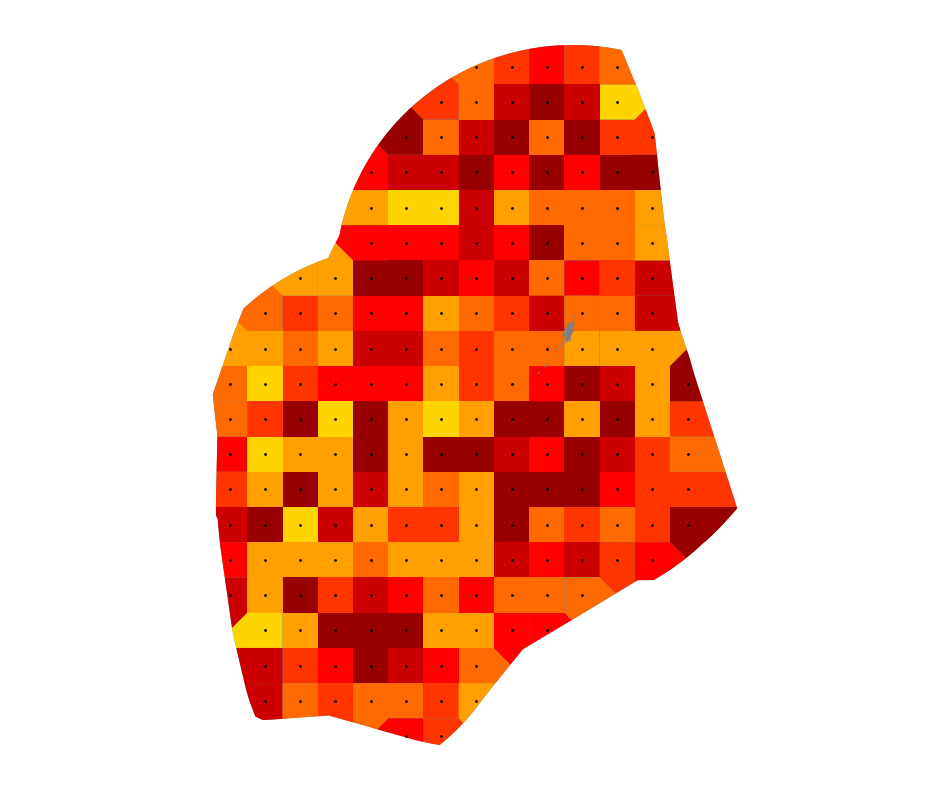

./CFS/sstgeojson/CFS2021.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


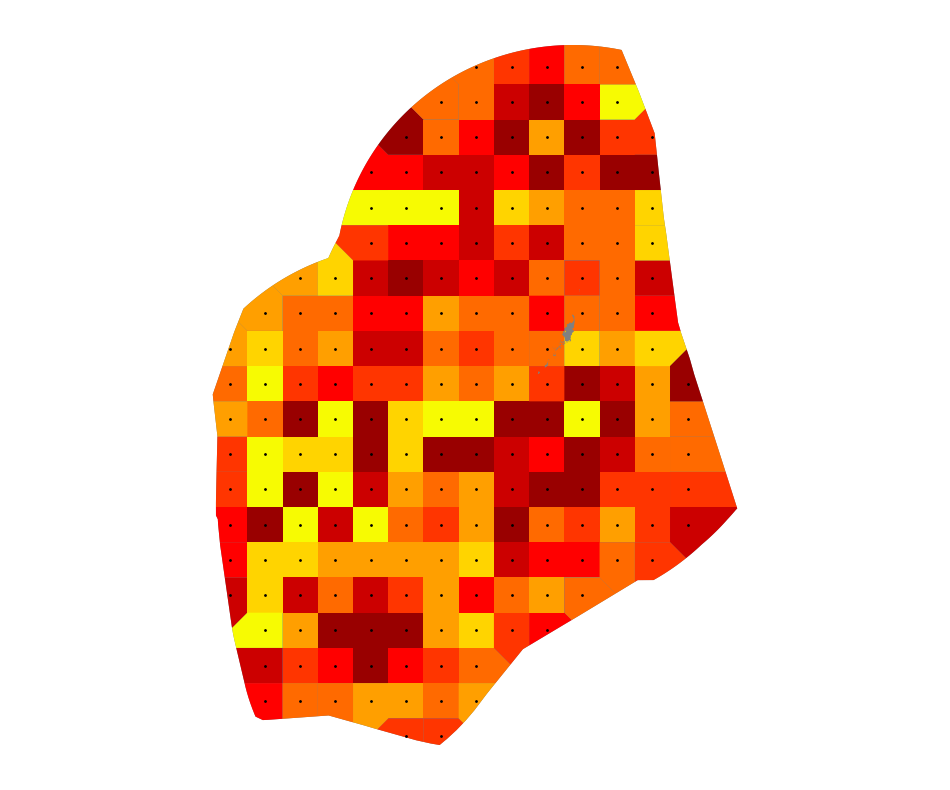

./CFS/sstgeojson/CFS2022.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3223539765.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


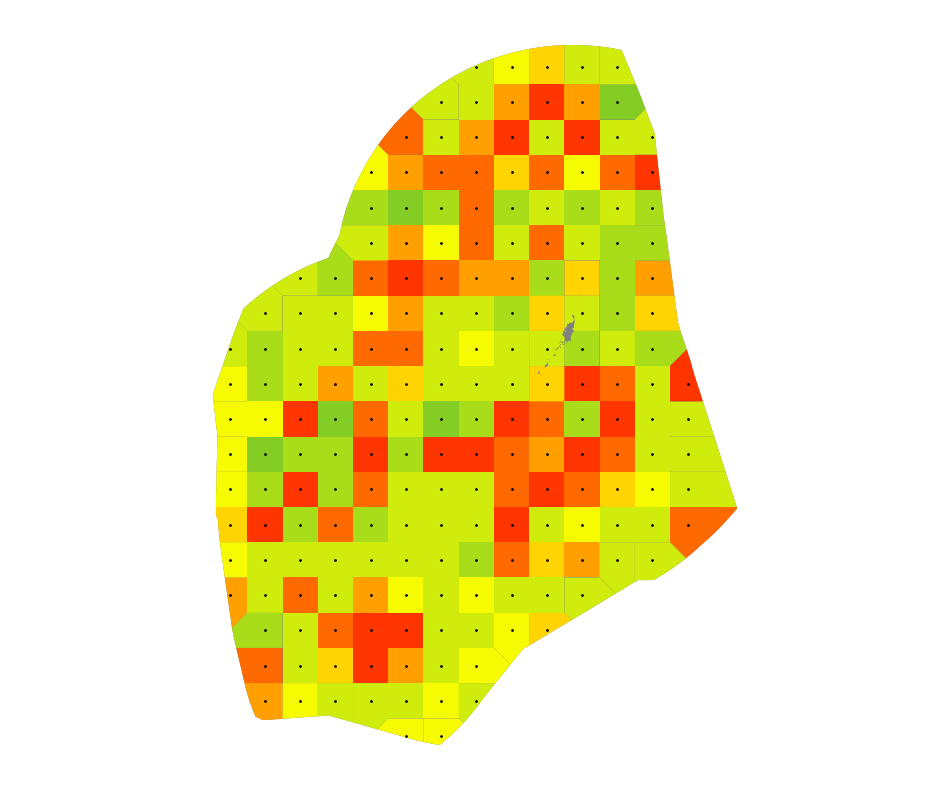

./CFS/sstgeojson/CFS2023.json


In [25]:
geojson_folder = "./CFS/sstgeojson/"

if not os.path.exists(geojson_folder):
    os.makedirs(geojson_folder)
    
colorbar_folder = '.CFS/colorbar/'
if not os.path.exists(colorbar_folder):
    os.makedirs(colorbar_folder)
    


master_cfs = pd.read_pickle("./CFS/pkl/master_CFS.pkl")

master_cfs = palau_eez(master_cfs)
year_range = str(min(master_cfs['year'].tolist())) + "-" + str(max(master_cfs['year'].tolist()))
colorbar_name = year_range + "CFScolorbar"+ ".png"

colorbar_mpl(master_cfs, colorbar_folder + colorbar_name)
print("Created: " +colorbar_name)
for year in sorted(set(master_cfs['year'].tolist())):
    currgeo = getGridGeoJSON(year,master_cfs)
    json_object = json.dumps(currgeo, indent=4)

    geojson_dir = geojson_folder + "CFS" + str(year) +".json"
    with open(geojson_dir, "w") as outfile:
        outfile.write(json_object)
        print(geojson_dir)

In [30]:
crw_df = pd.read_pickle('./CRW/average/pkl/master_CRW.pkl')
crw_df = crw_df[['latitude','longitude','year','CRW_SST']]

In [33]:
crw_df = crw_df.rename(columns={"CRW_SST": "sst"})

Created: 1985-2023CRWcolorbar.png


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


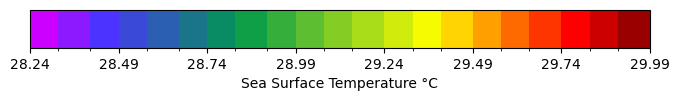

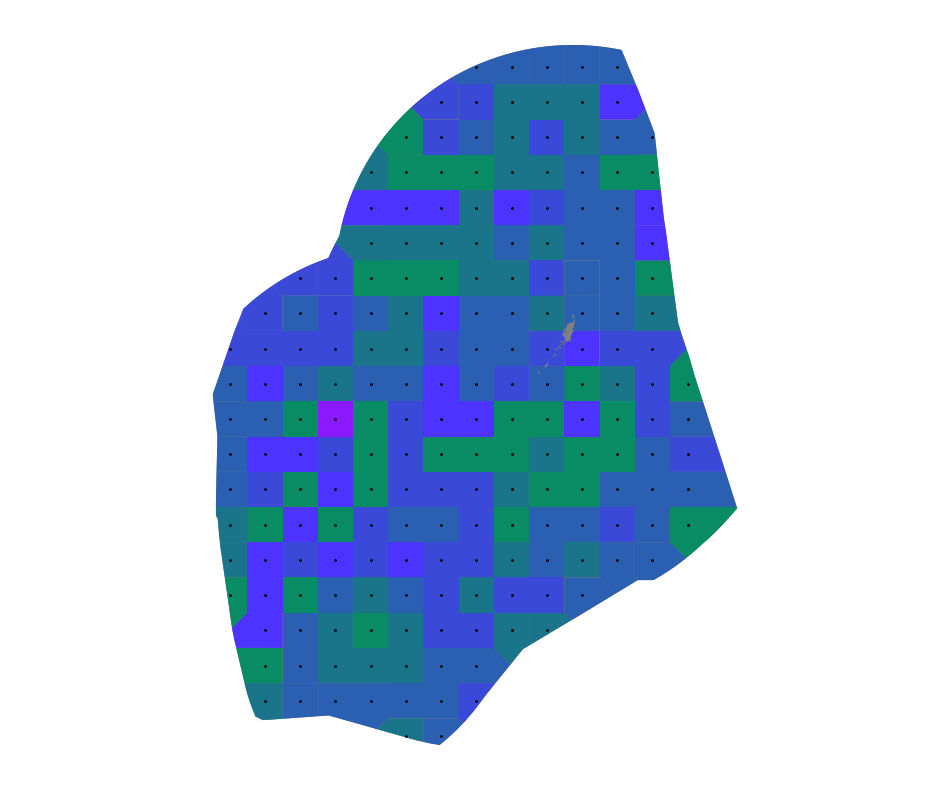

./CRW/sstgeojson/CFS1985.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


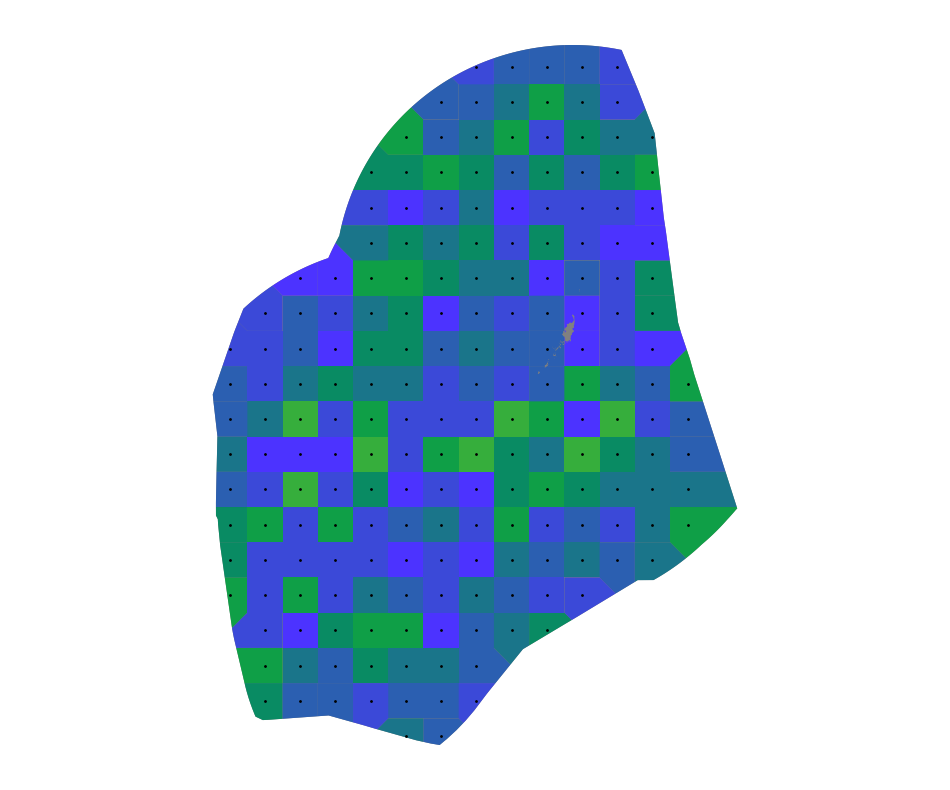

./CRW/sstgeojson/CFS1986.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


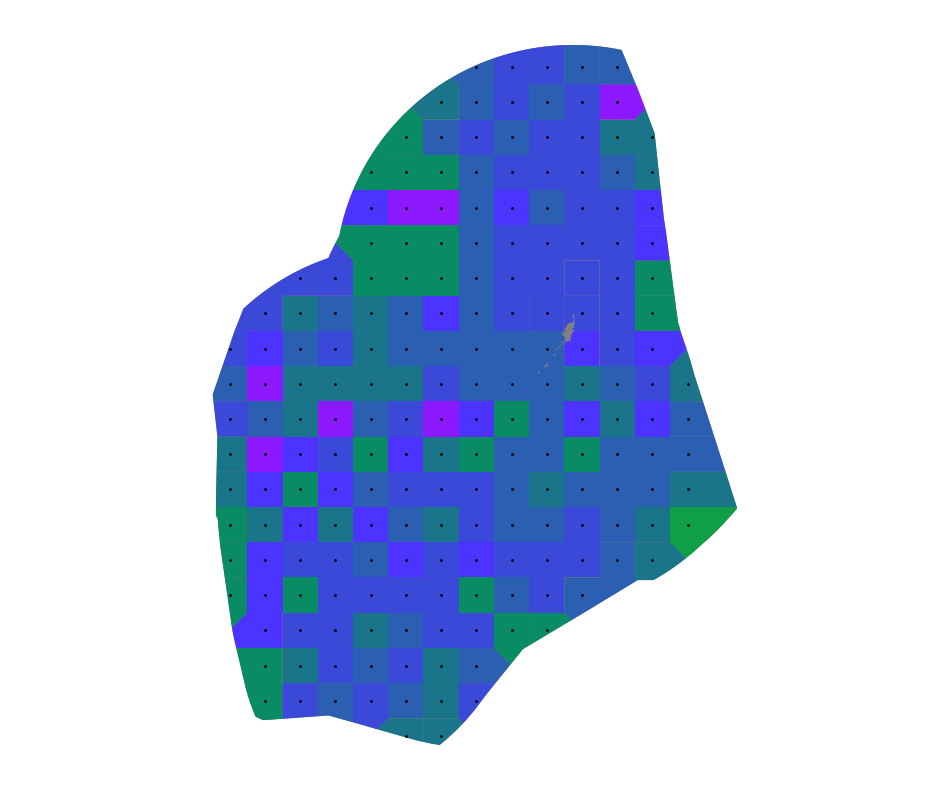

./CRW/sstgeojson/CFS1987.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


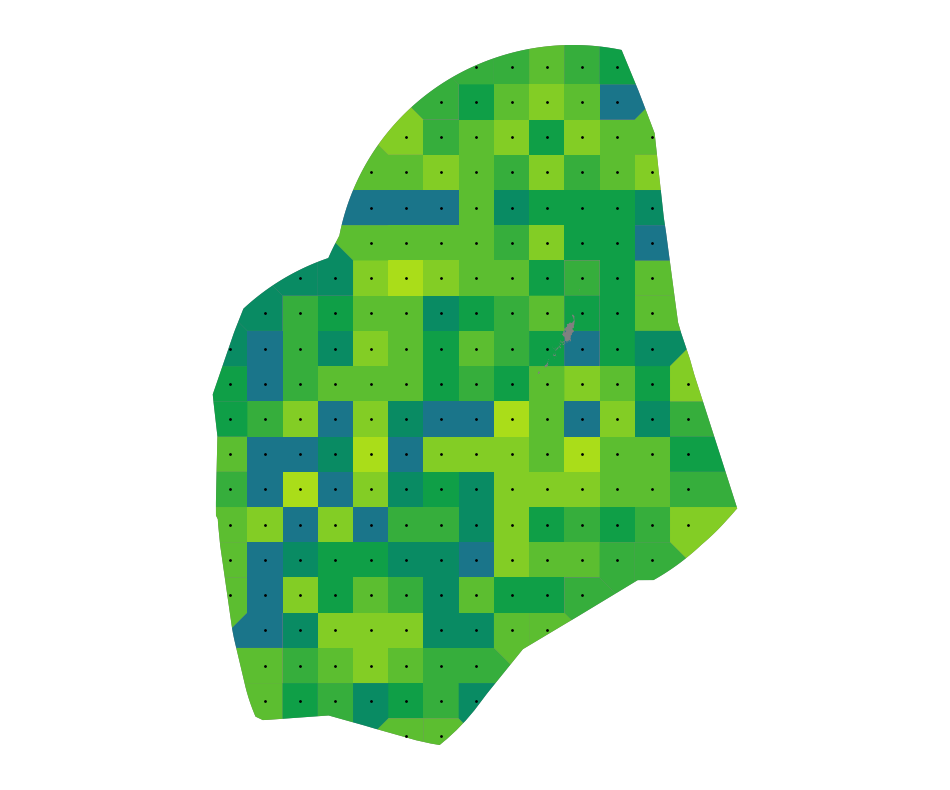

./CRW/sstgeojson/CFS1988.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


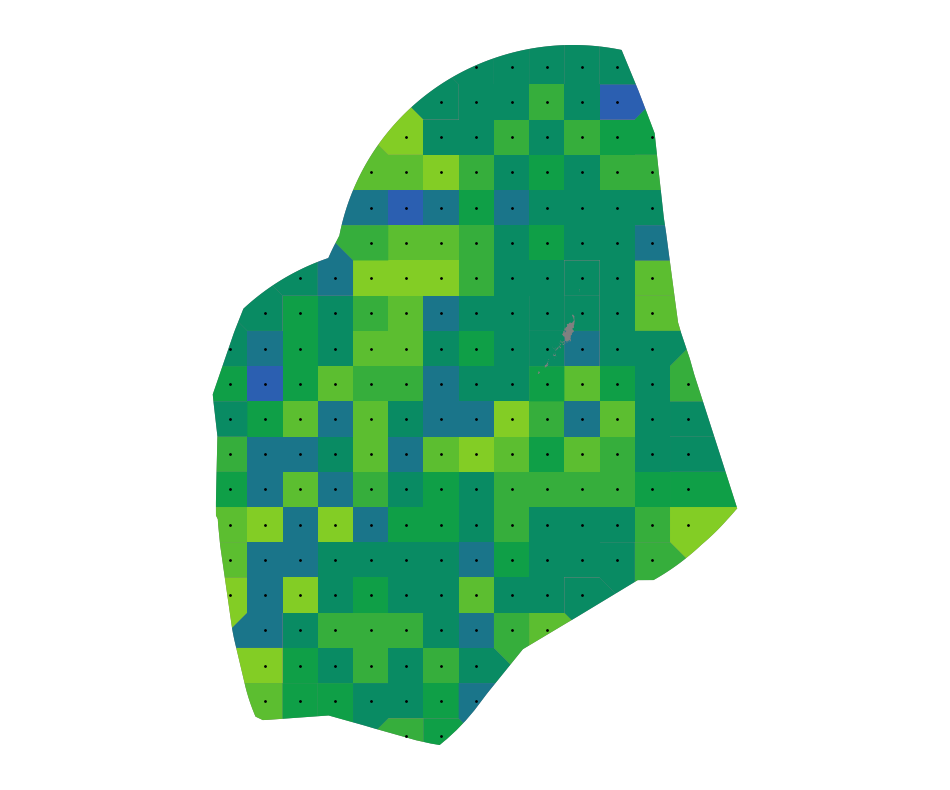

./CRW/sstgeojson/CFS1989.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


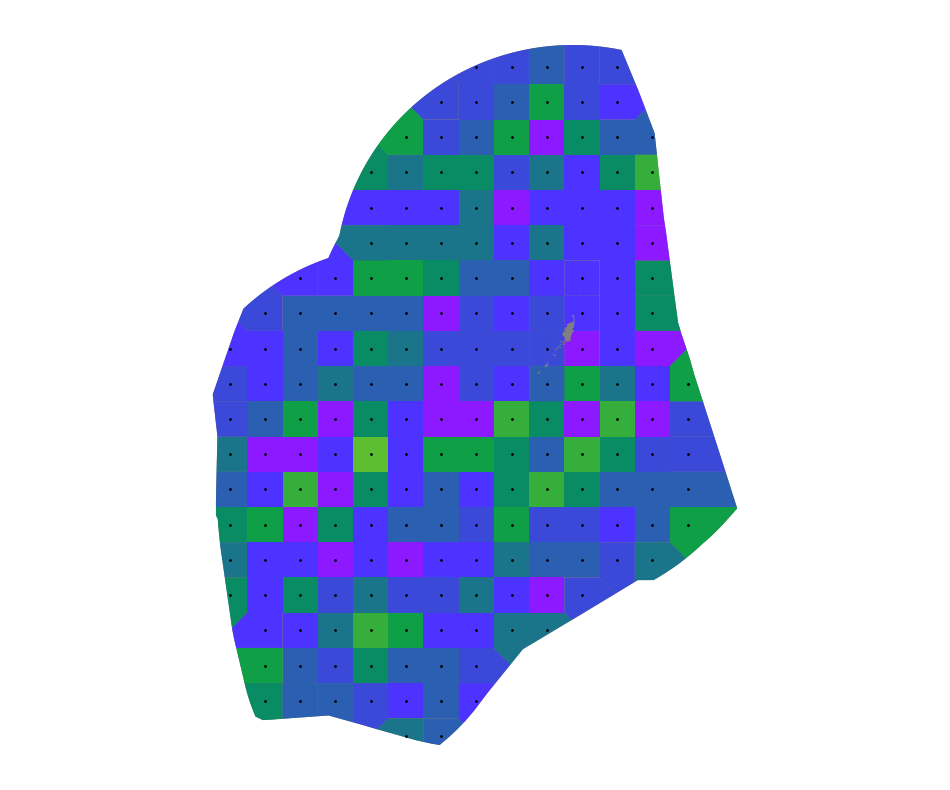

./CRW/sstgeojson/CFS1990.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


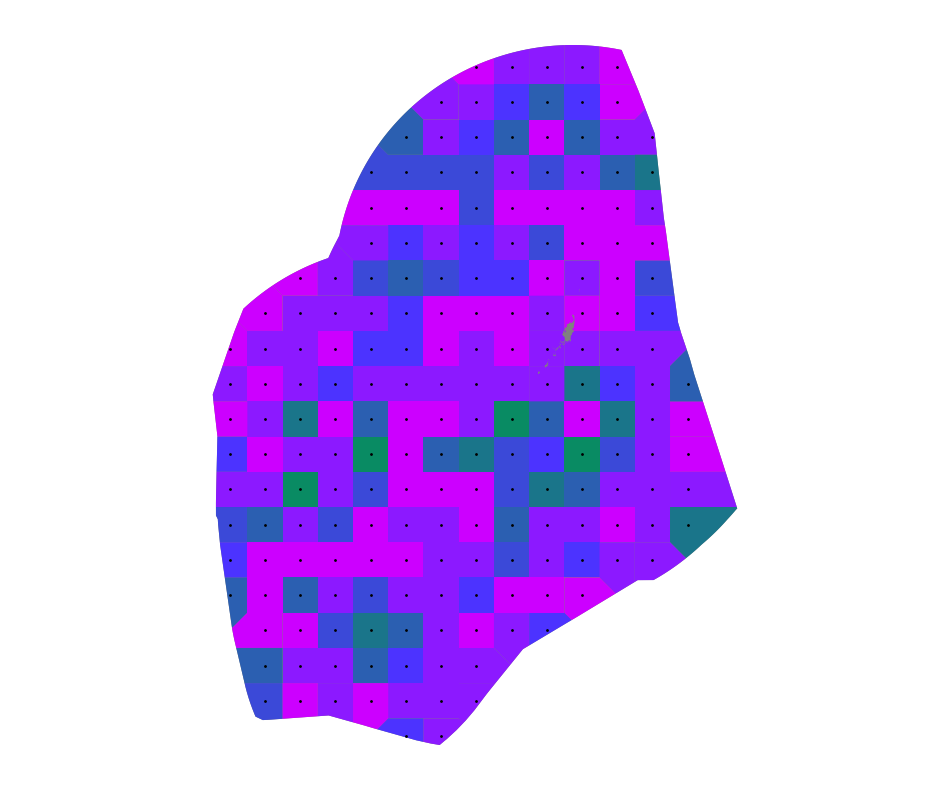

./CRW/sstgeojson/CFS1991.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


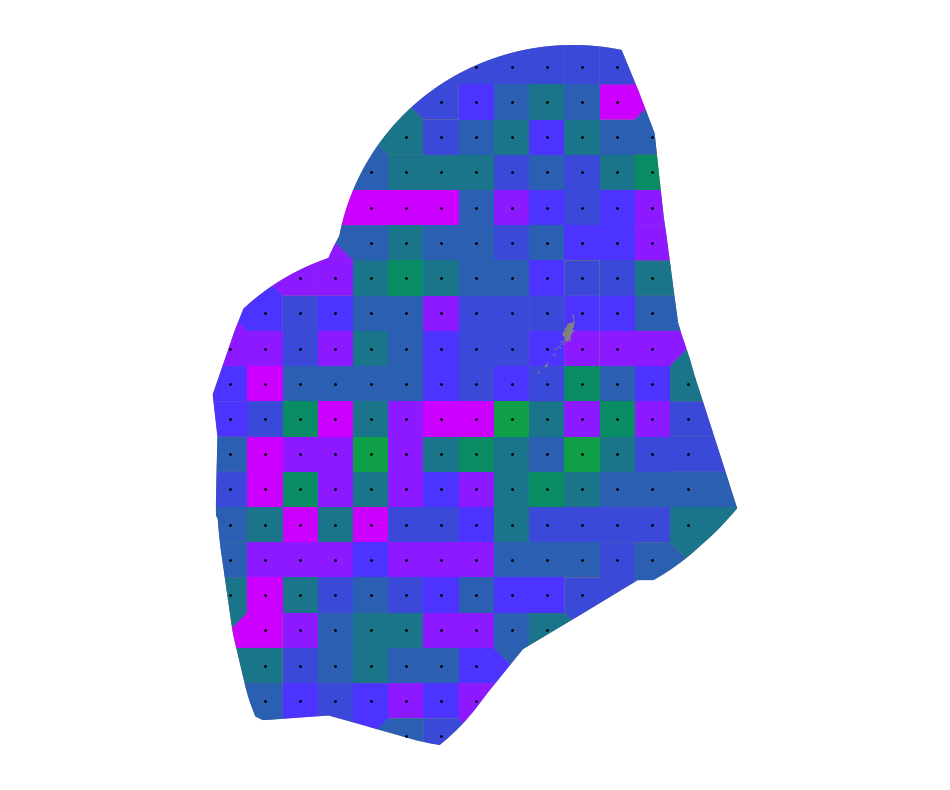

./CRW/sstgeojson/CFS1992.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


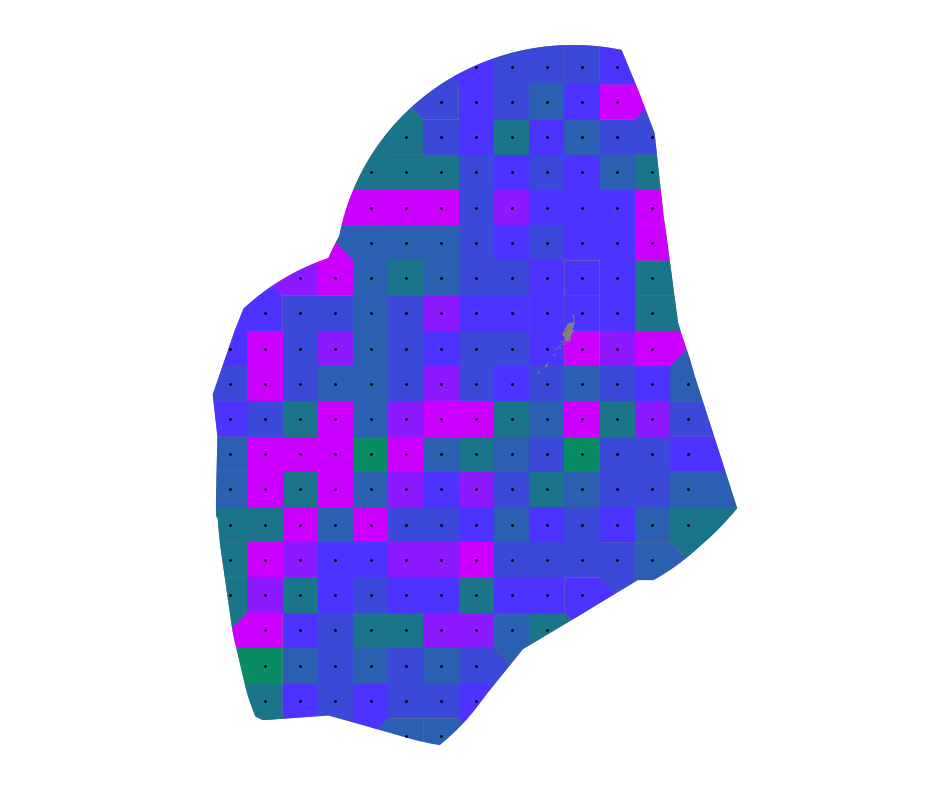

./CRW/sstgeojson/CFS1993.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


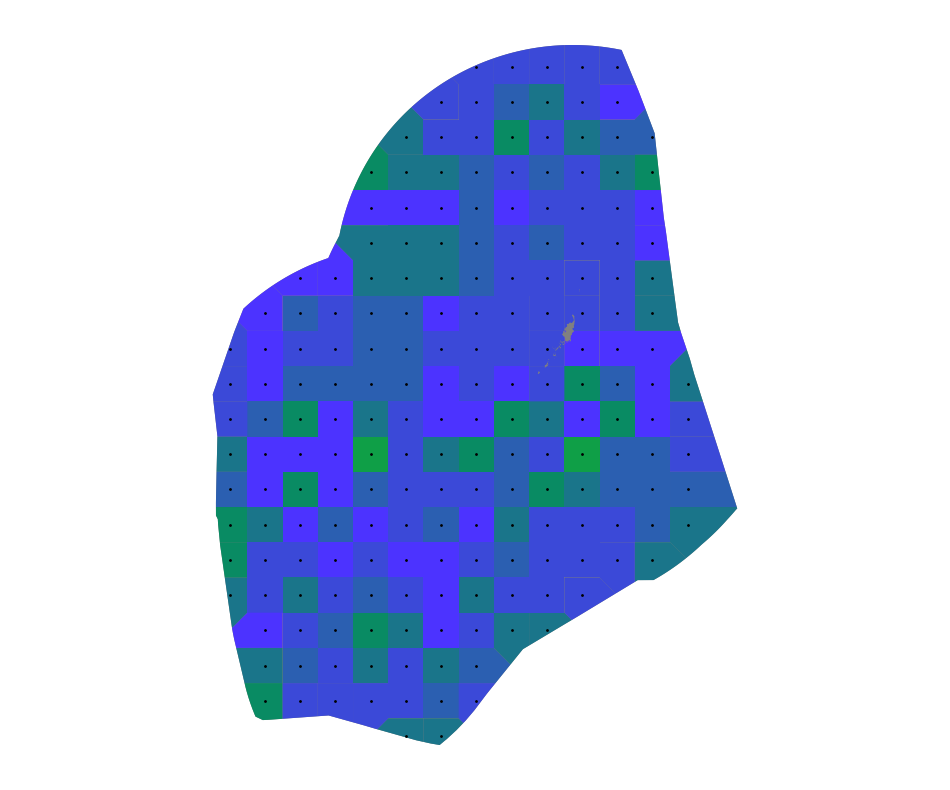

./CRW/sstgeojson/CFS1994.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


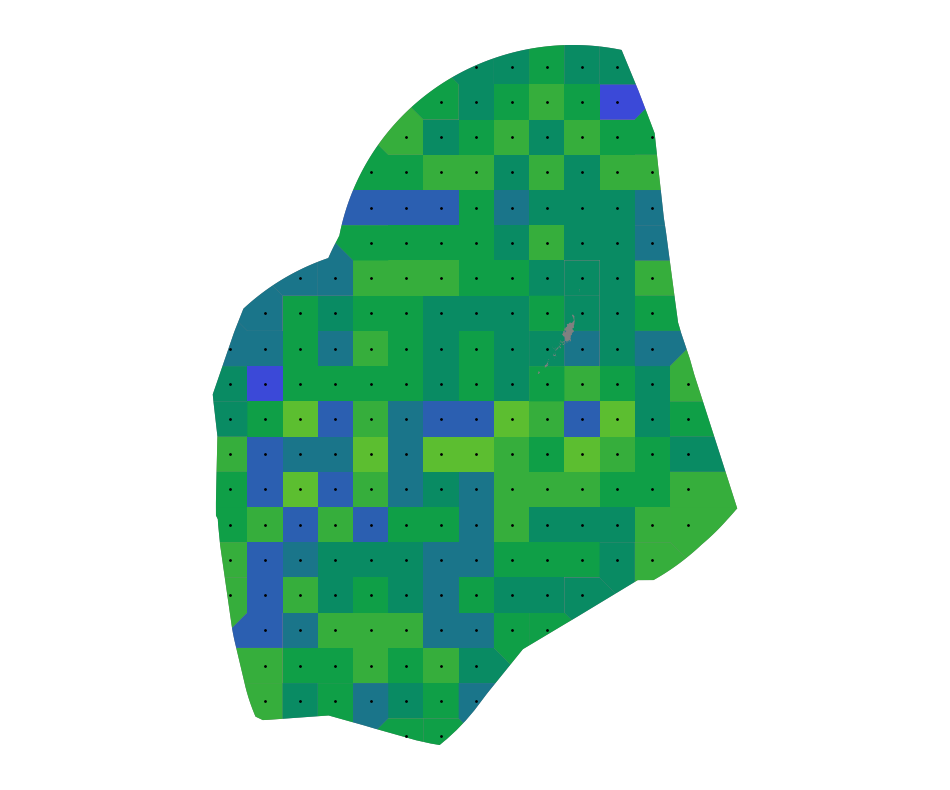

./CRW/sstgeojson/CFS1995.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


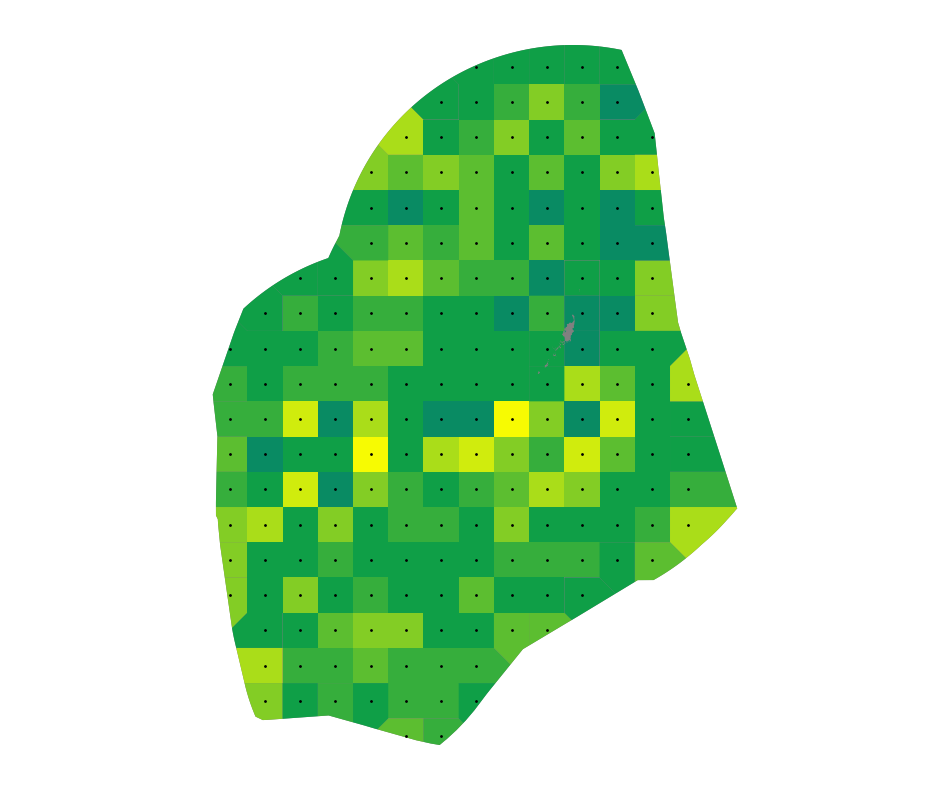

./CRW/sstgeojson/CFS1996.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


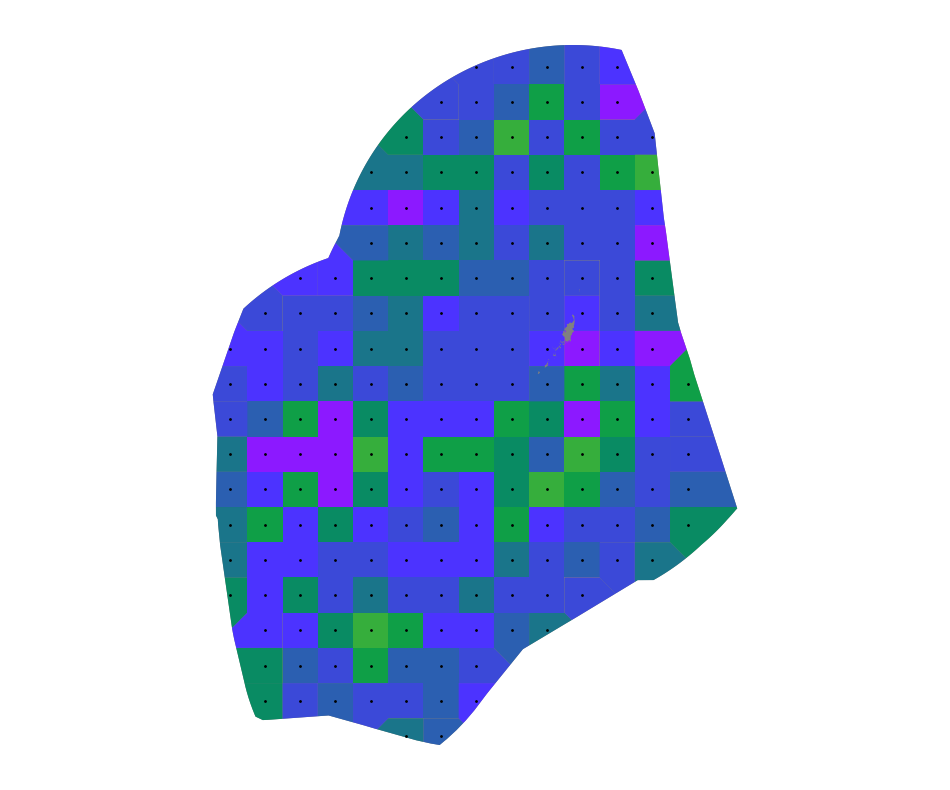

./CRW/sstgeojson/CFS1997.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


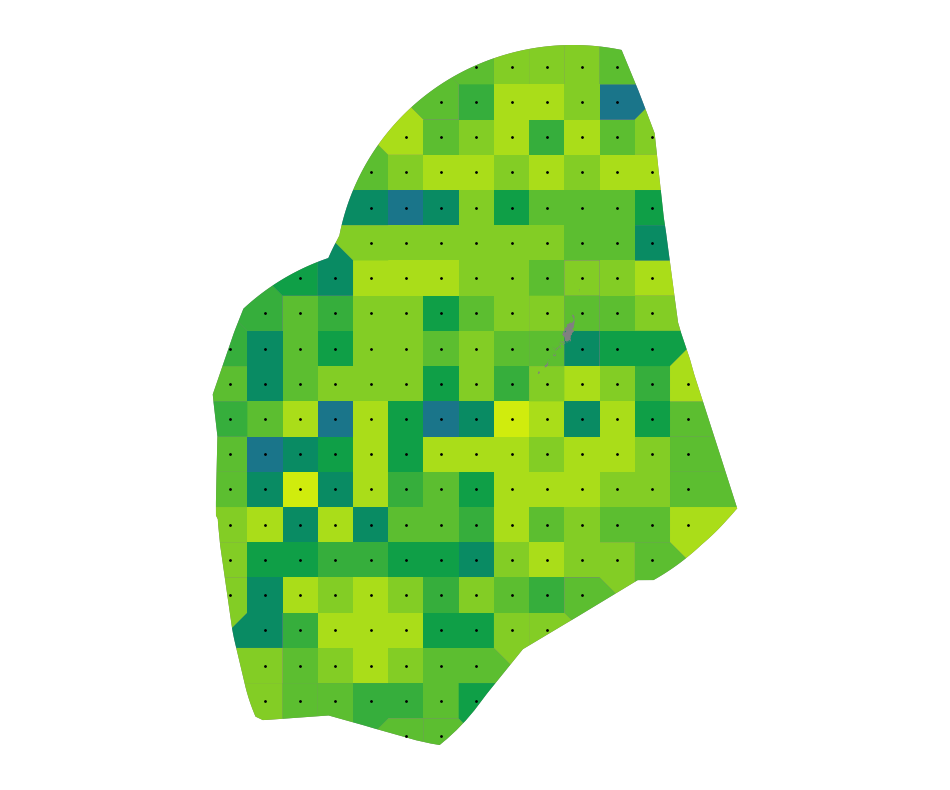

./CRW/sstgeojson/CFS1998.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


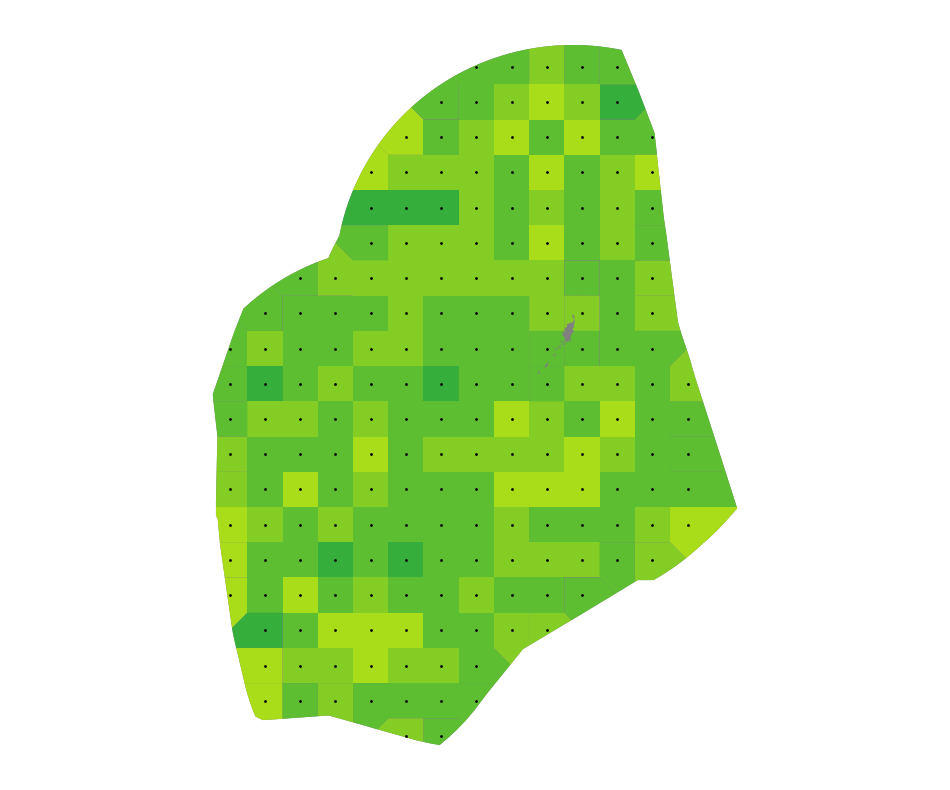

./CRW/sstgeojson/CFS1999.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


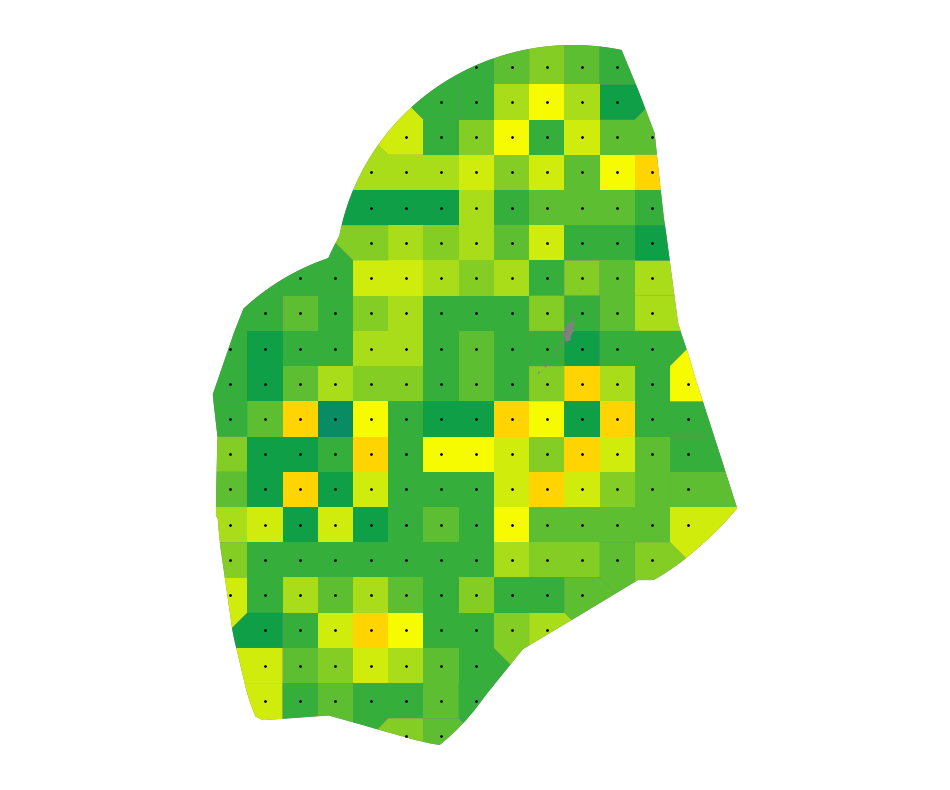

./CRW/sstgeojson/CFS2000.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


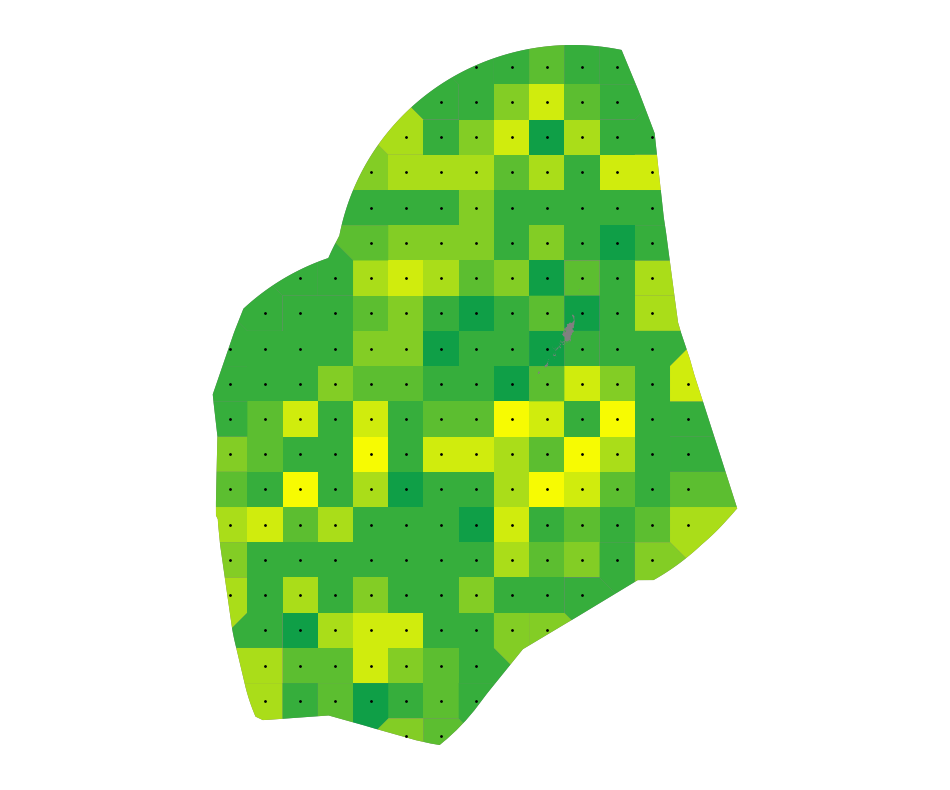

./CRW/sstgeojson/CFS2001.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


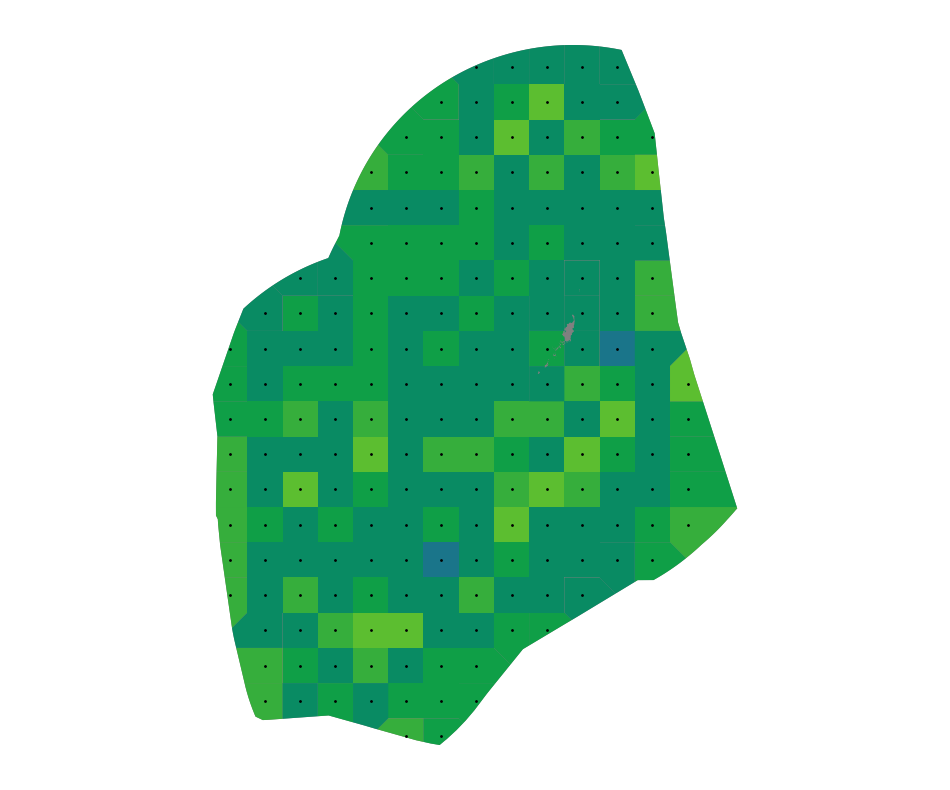

./CRW/sstgeojson/CFS2002.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


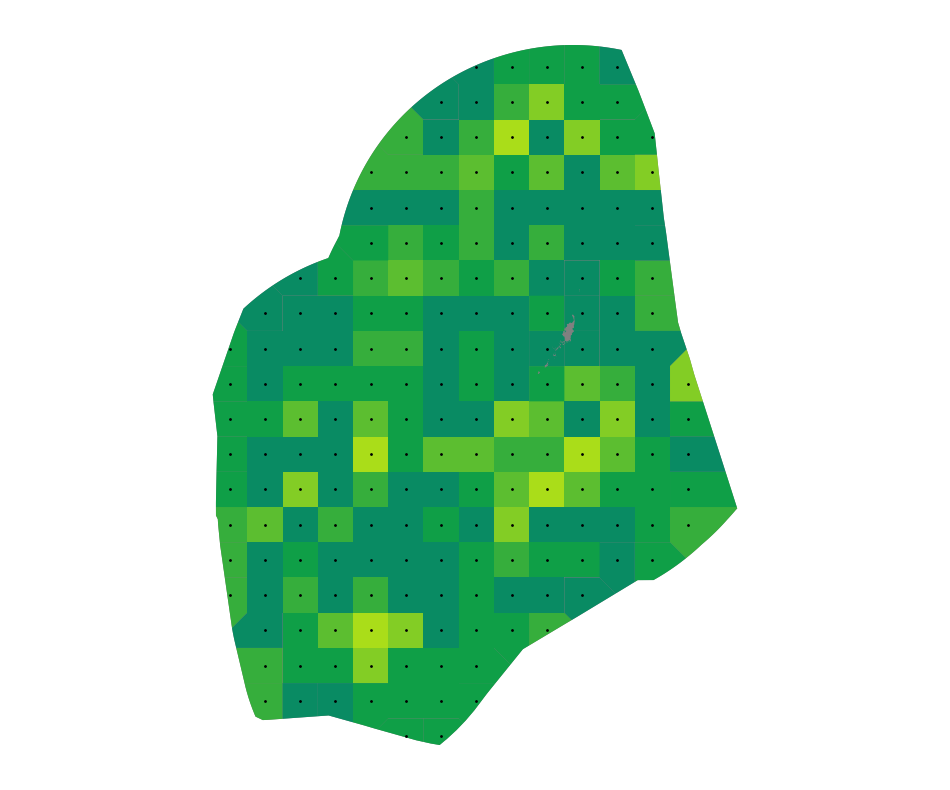

./CRW/sstgeojson/CFS2003.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


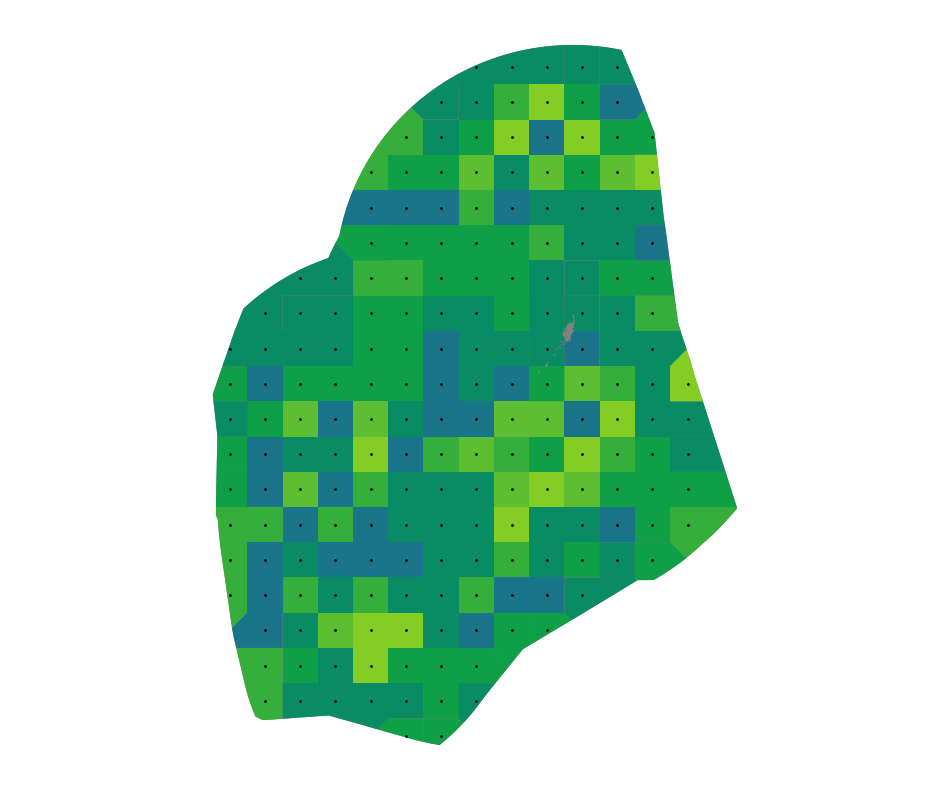

./CRW/sstgeojson/CFS2004.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


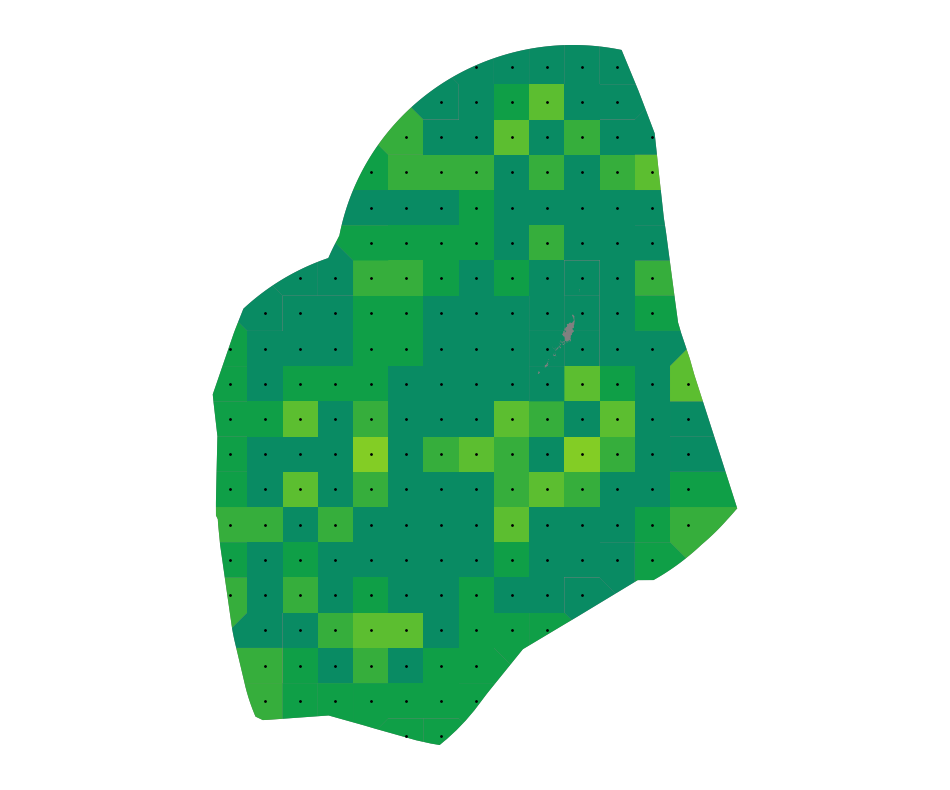

./CRW/sstgeojson/CFS2005.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


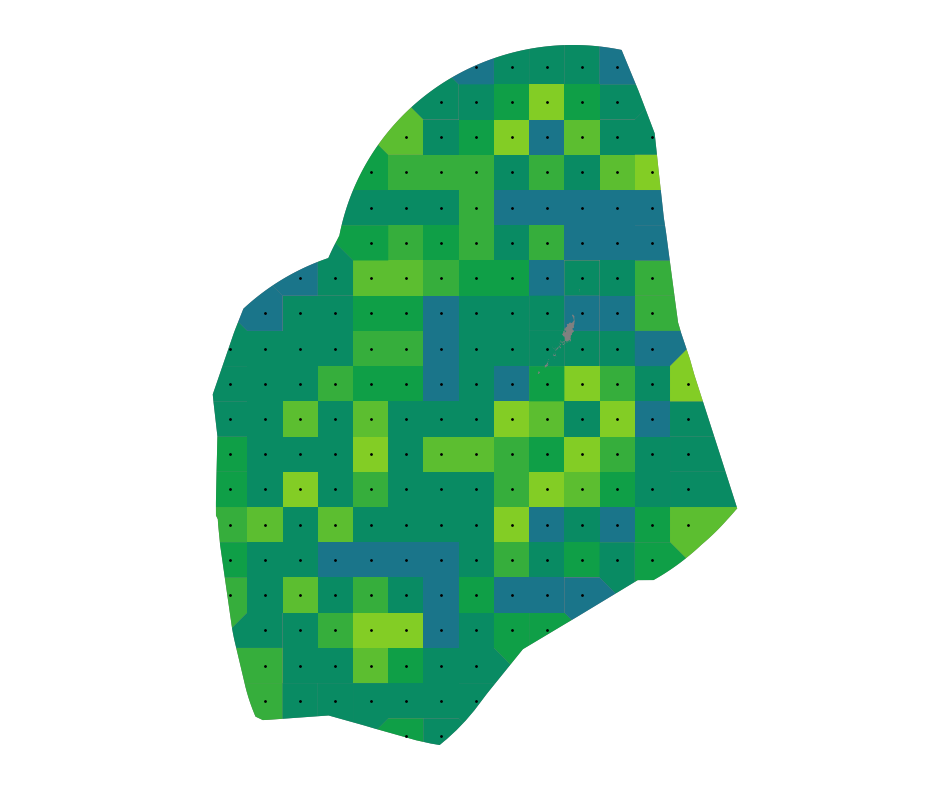

./CRW/sstgeojson/CFS2006.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


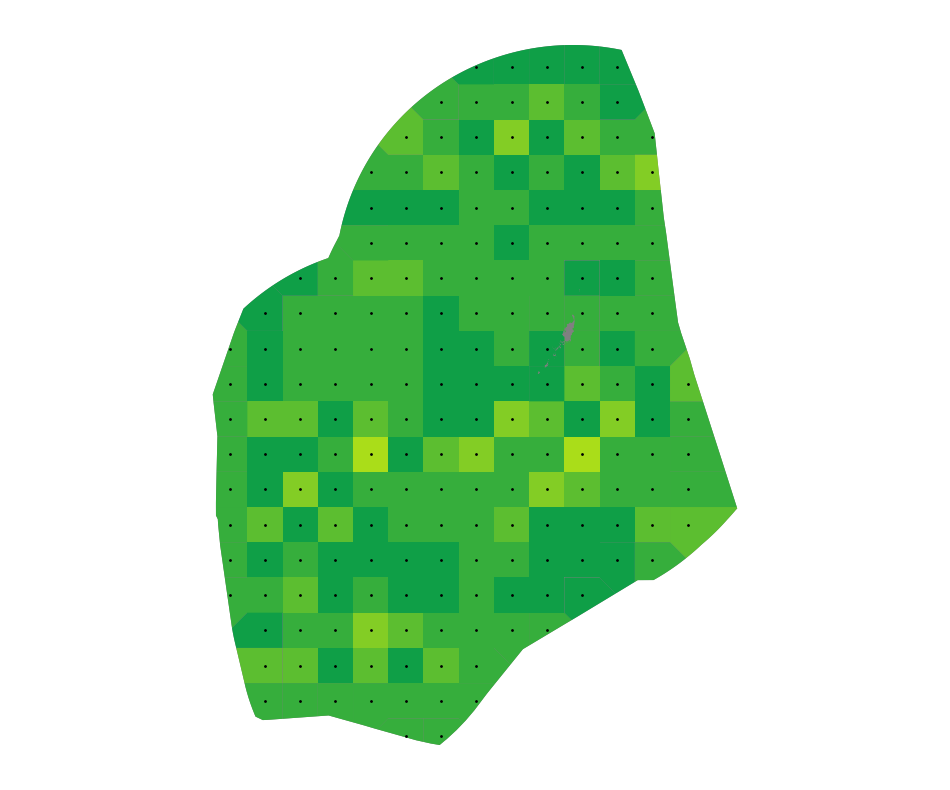

./CRW/sstgeojson/CFS2007.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


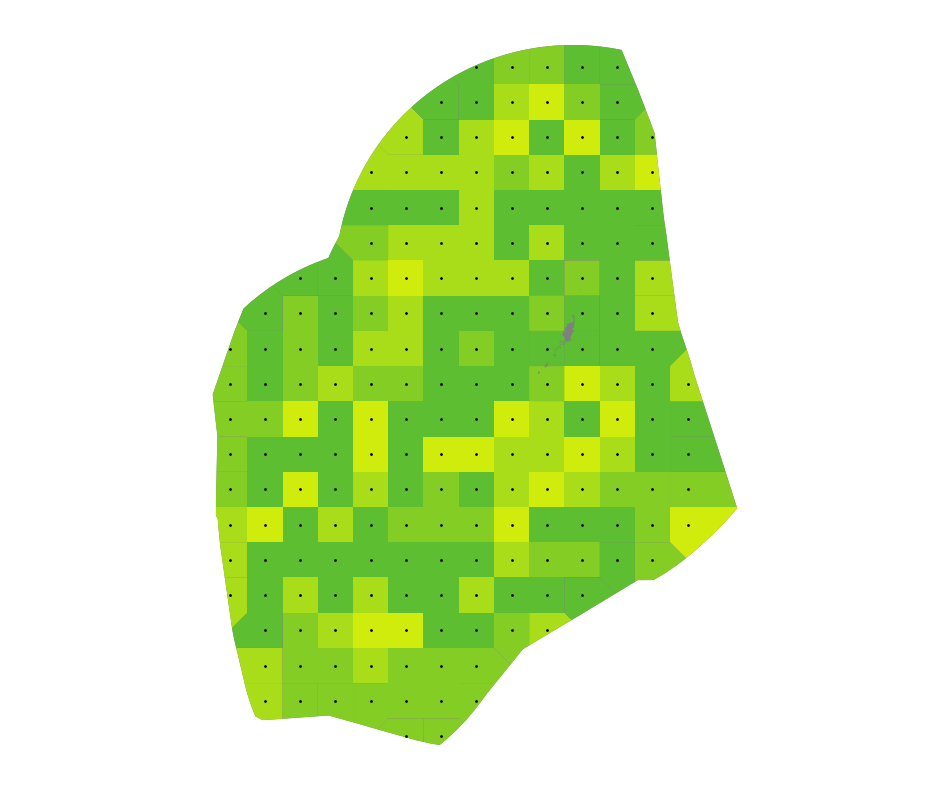

./CRW/sstgeojson/CFS2008.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


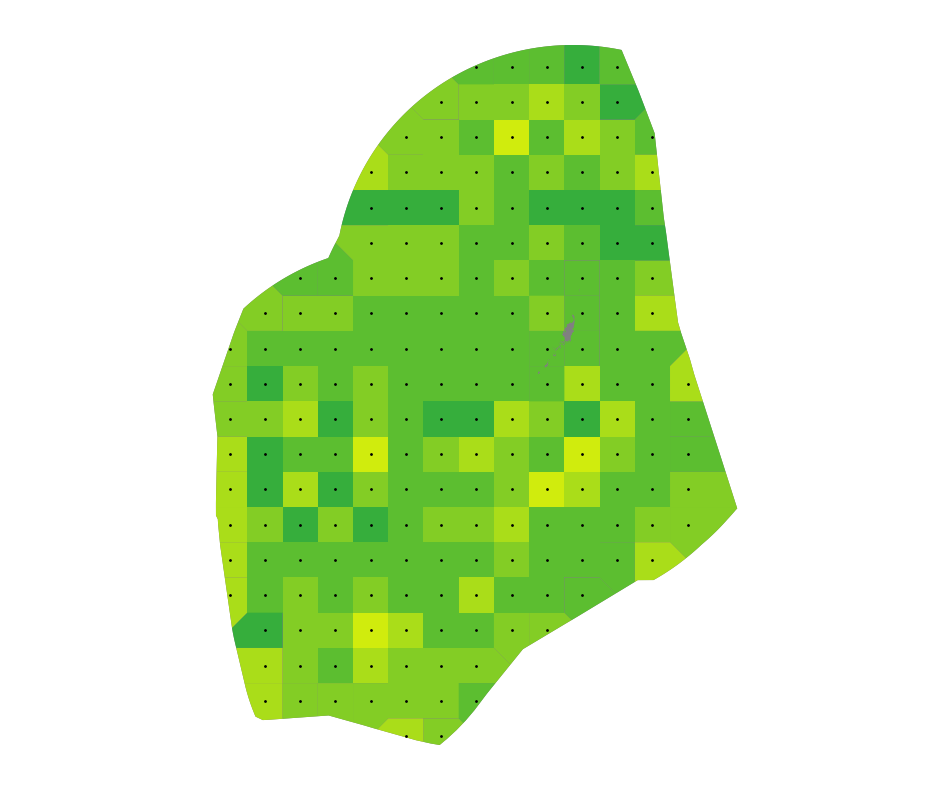

./CRW/sstgeojson/CFS2009.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


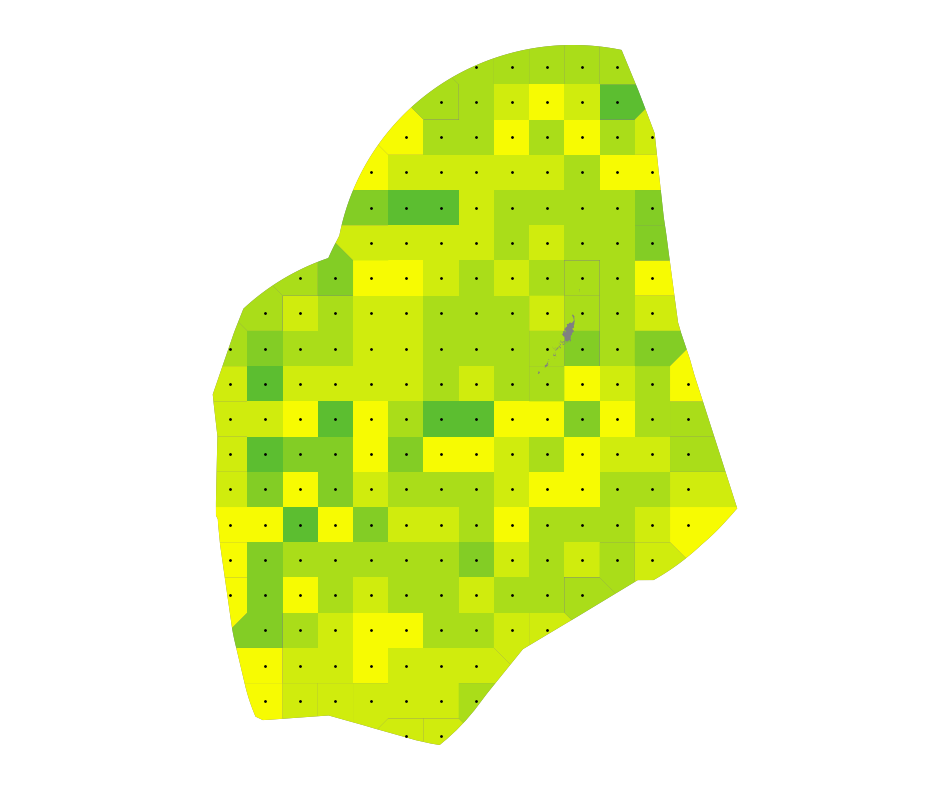

./CRW/sstgeojson/CFS2010.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


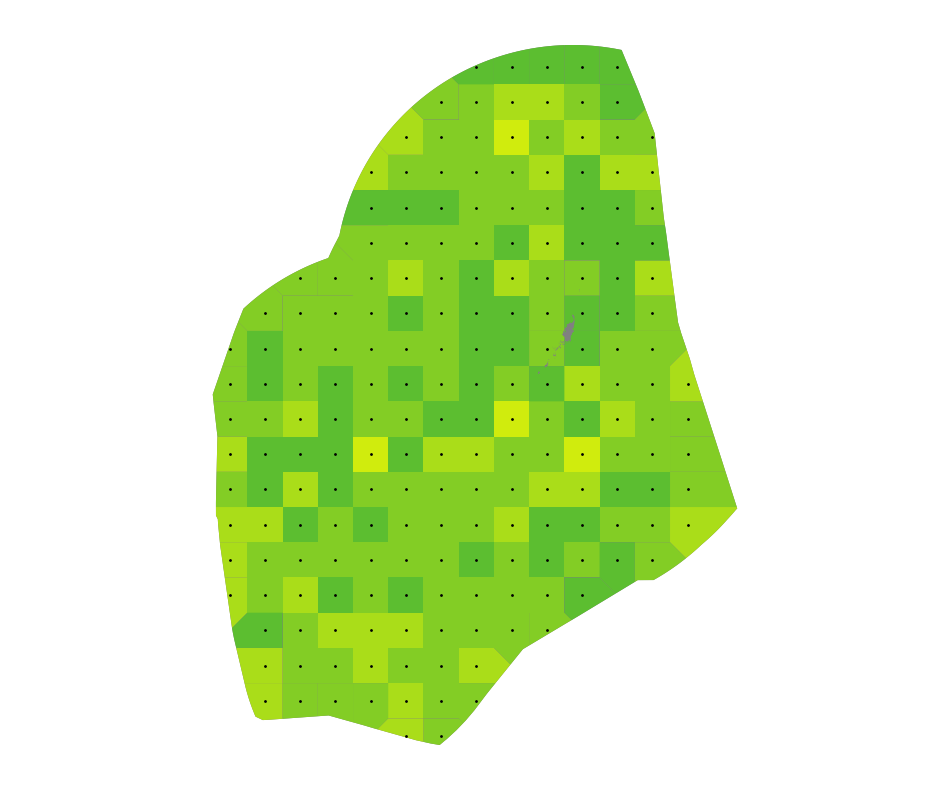

./CRW/sstgeojson/CFS2011.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


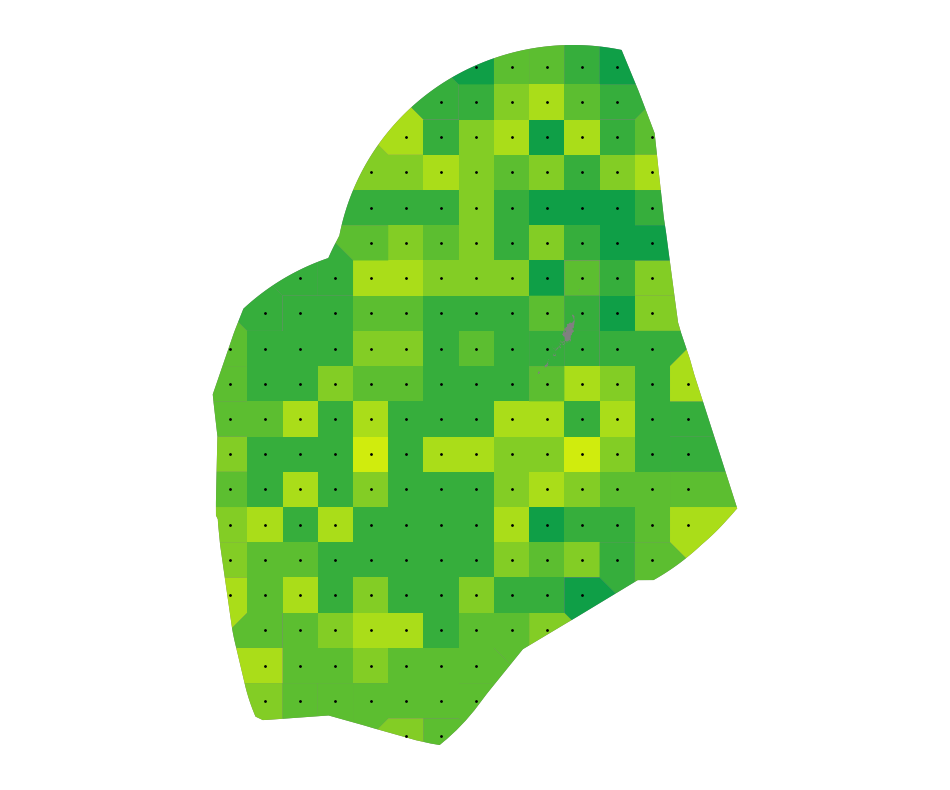

./CRW/sstgeojson/CFS2012.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


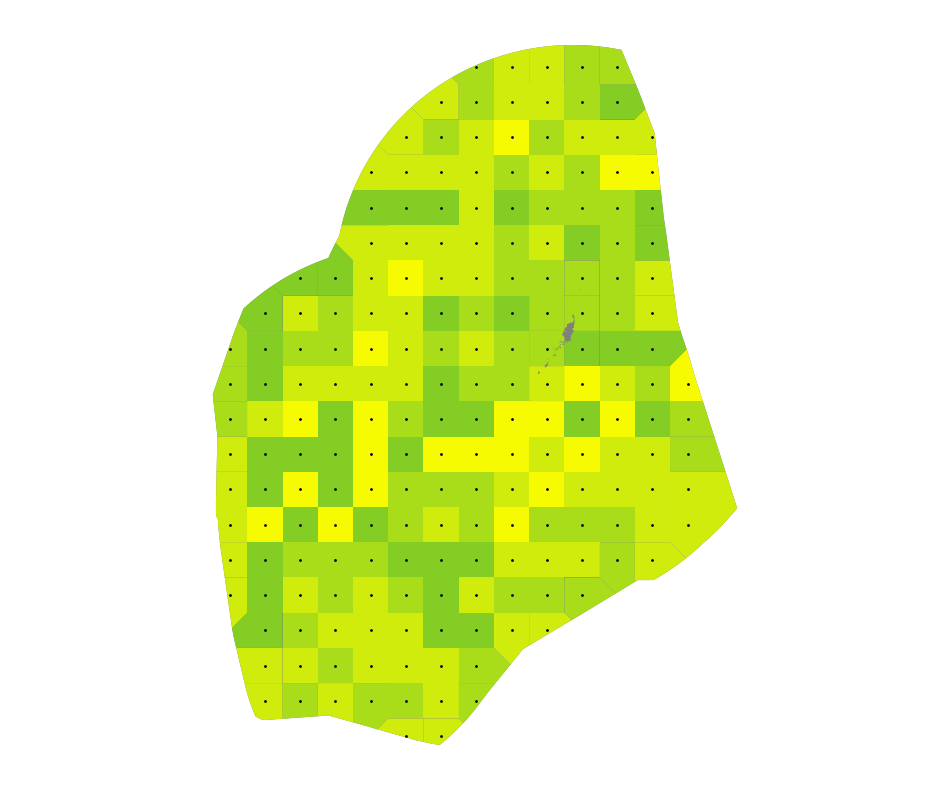

./CRW/sstgeojson/CFS2013.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


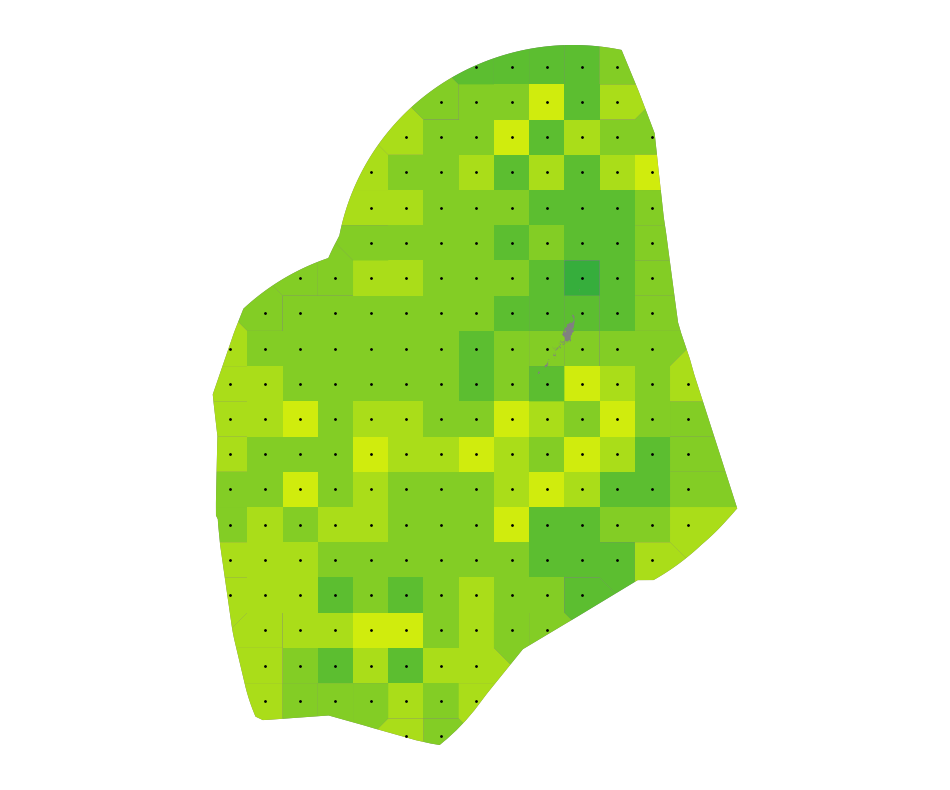

./CRW/sstgeojson/CFS2014.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


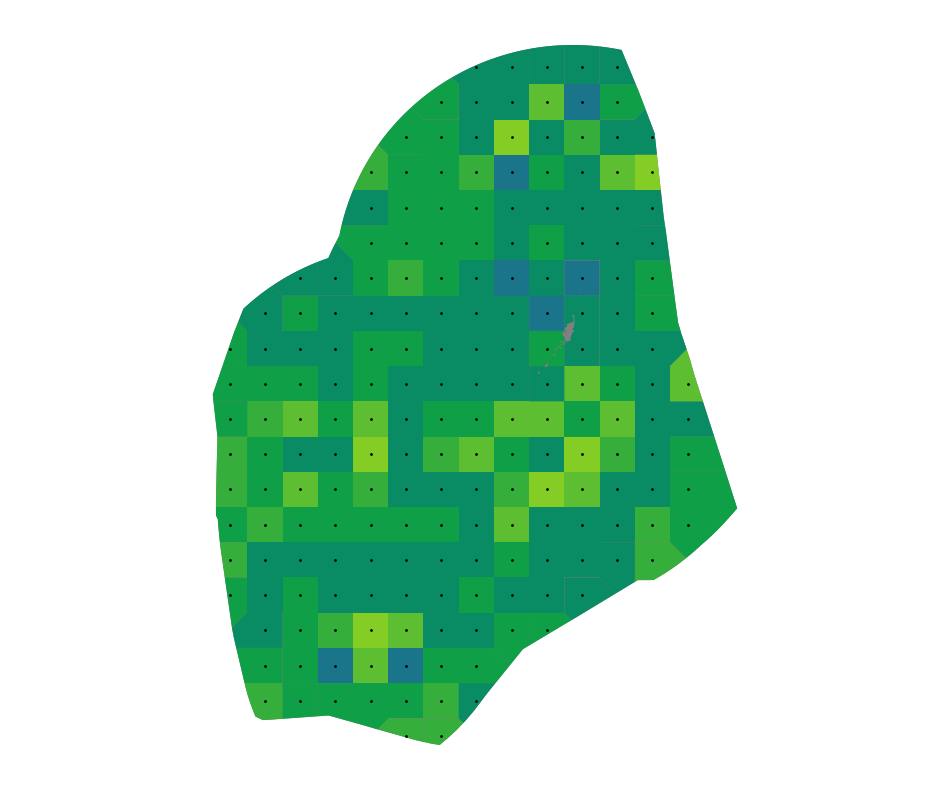

./CRW/sstgeojson/CFS2015.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


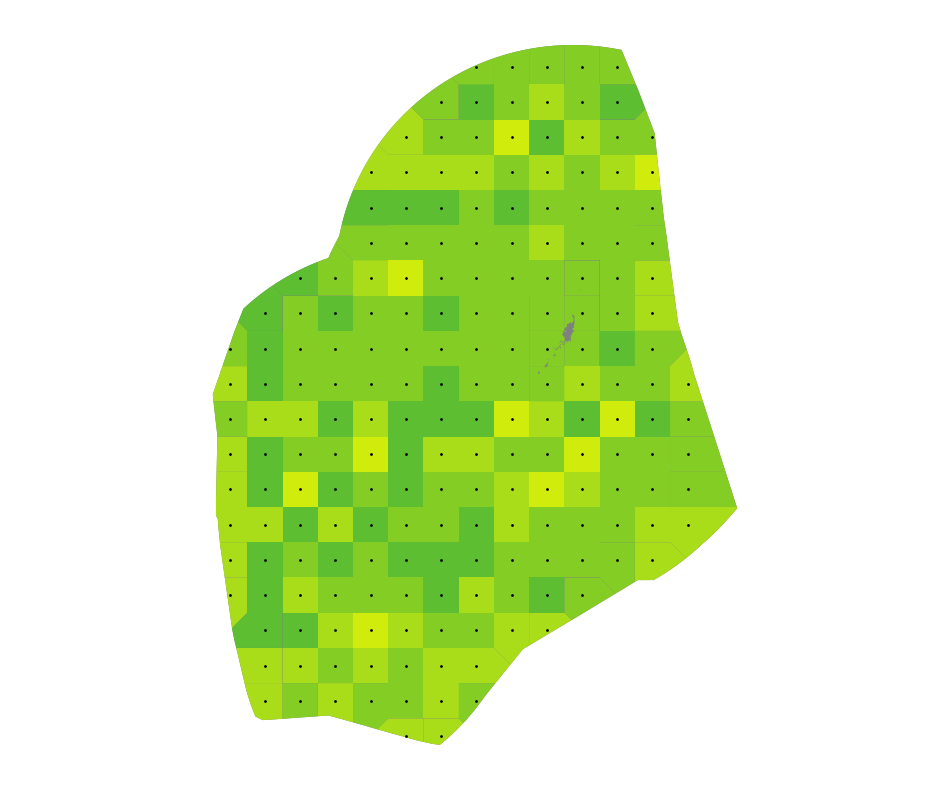

./CRW/sstgeojson/CFS2016.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


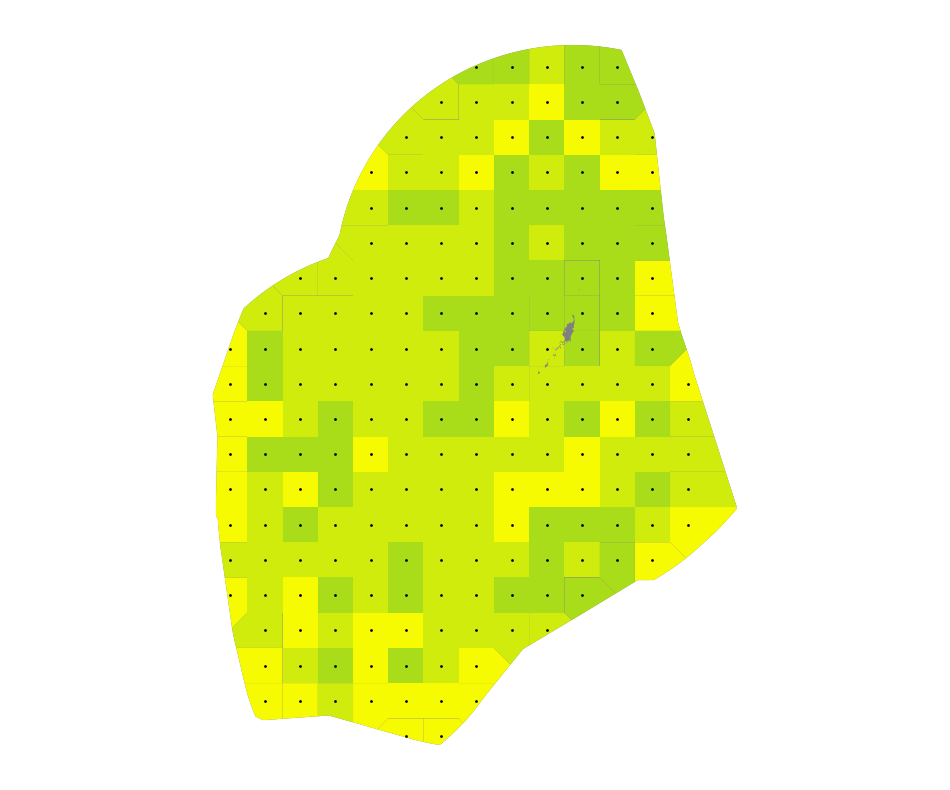

./CRW/sstgeojson/CFS2017.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


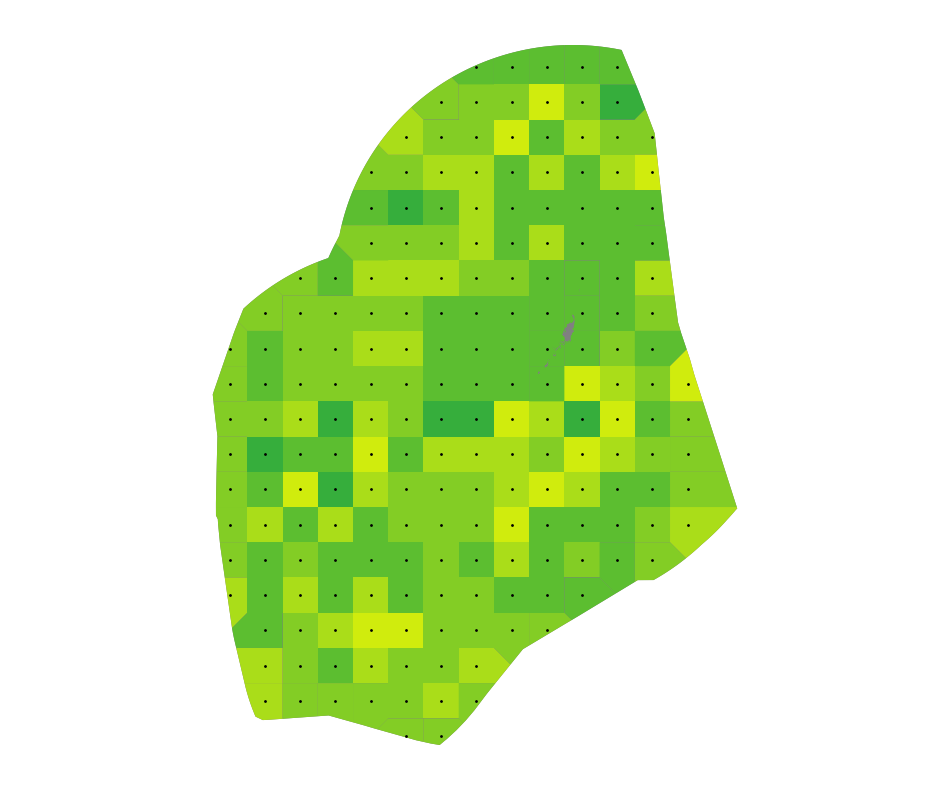

./CRW/sstgeojson/CFS2018.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


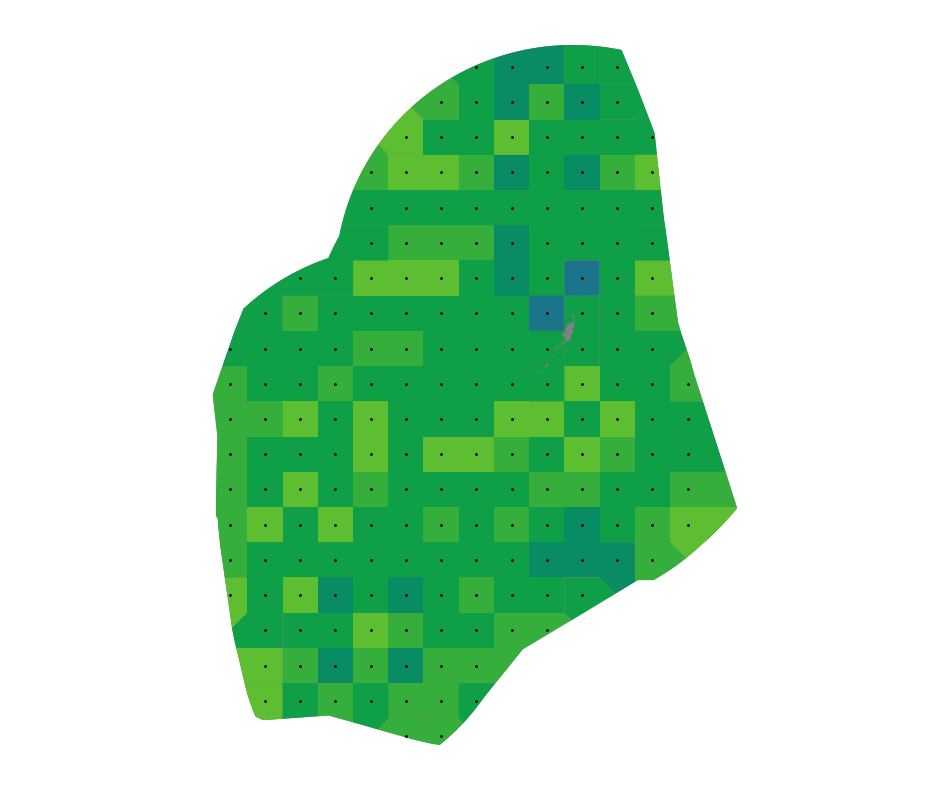

./CRW/sstgeojson/CFS2019.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


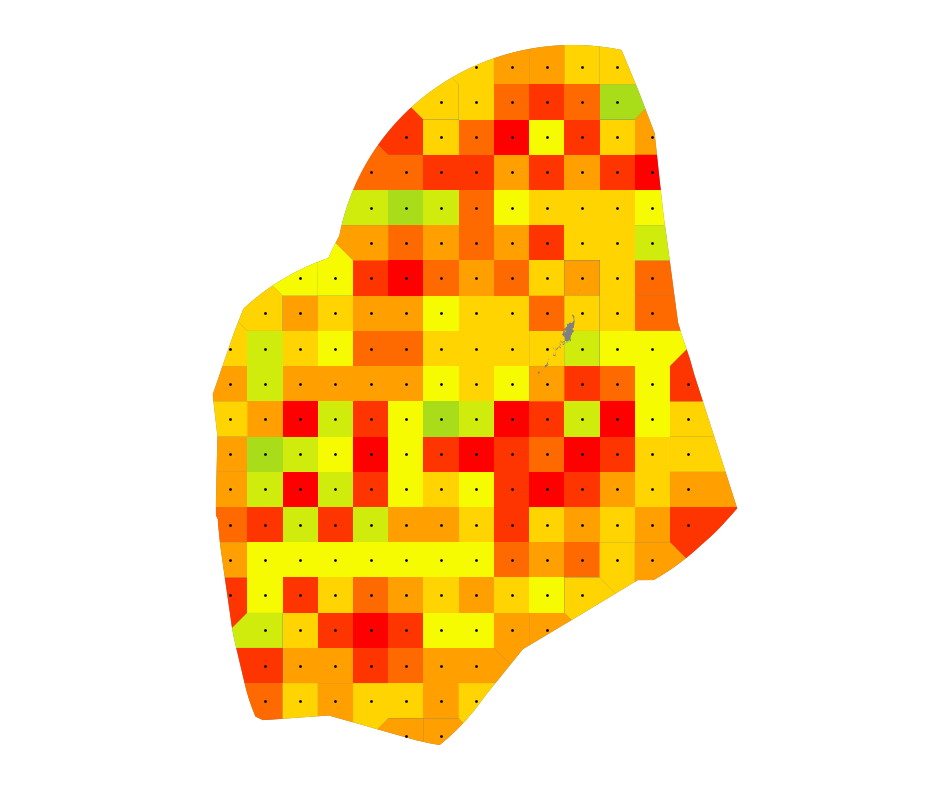

./CRW/sstgeojson/CFS2020.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


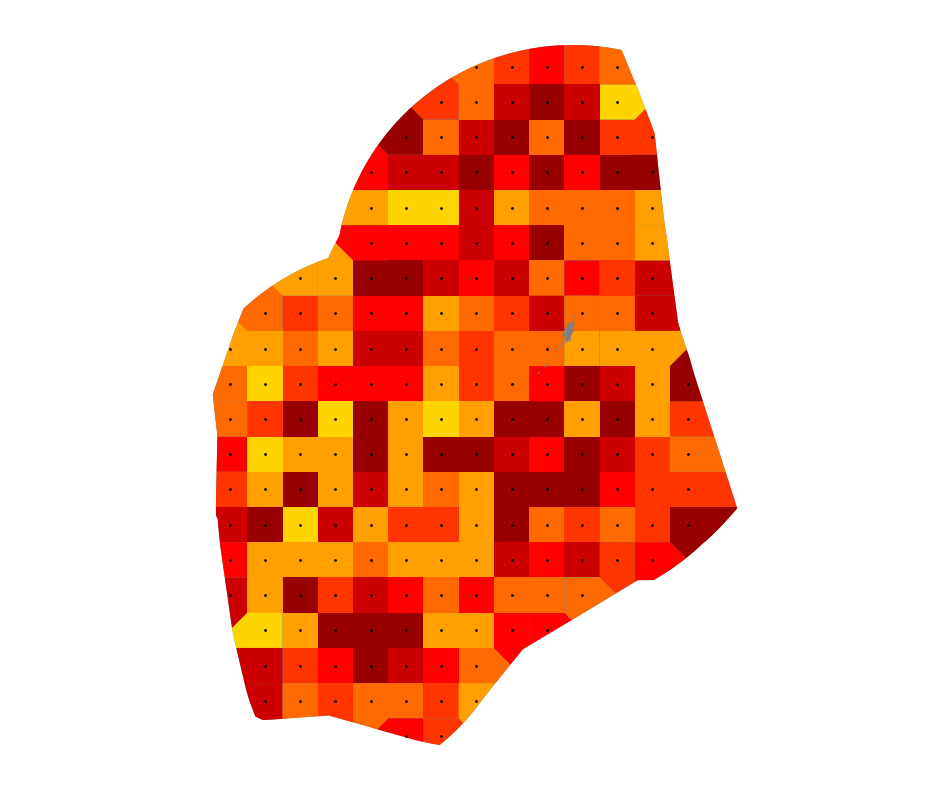

./CRW/sstgeojson/CFS2021.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


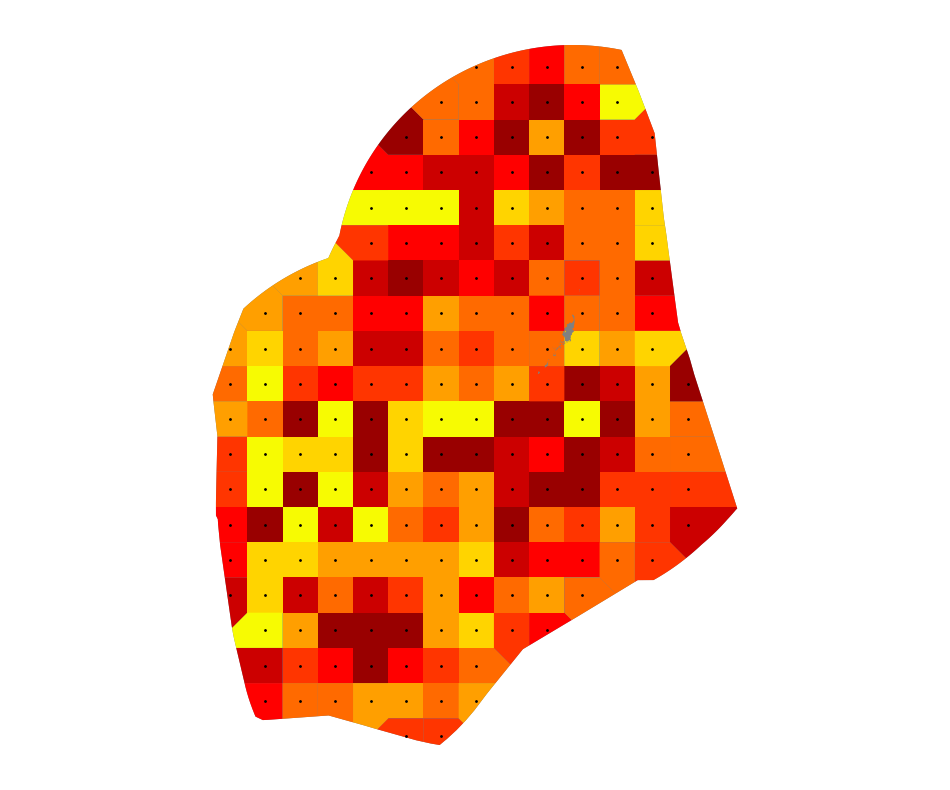

./CRW/sstgeojson/CFS2022.json


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_38539/3468559597.py:106: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


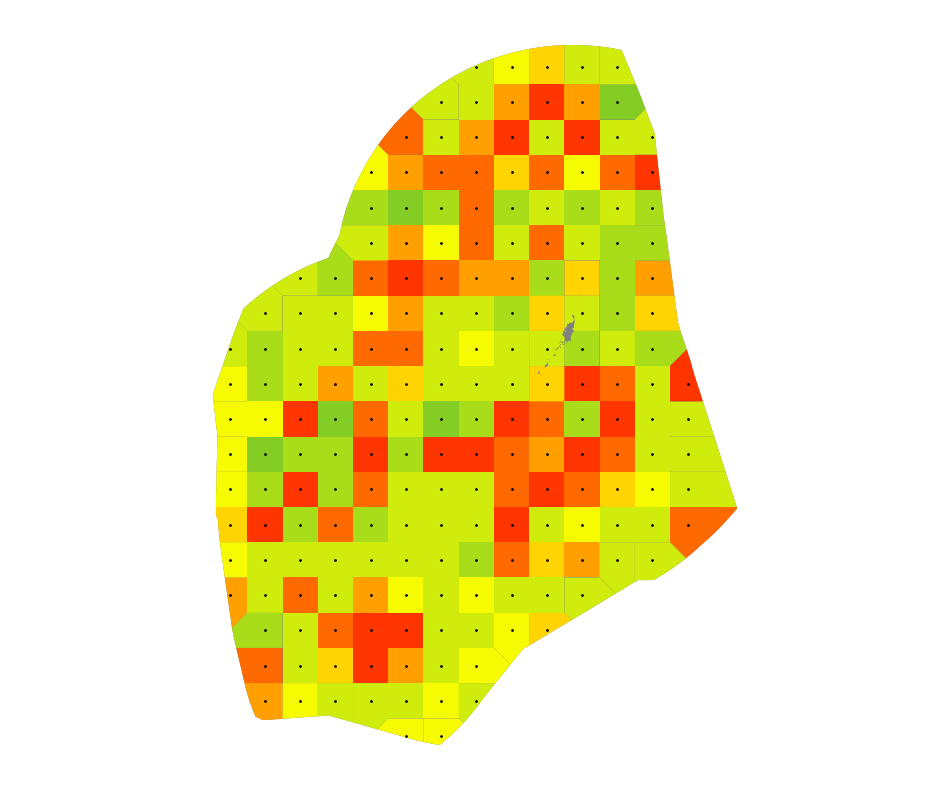

./CRW/sstgeojson/CFS2023.json


In [38]:
geojson_folder = "./CRW/sstgeojson/"

if not os.path.exists(geojson_folder):
    os.makedirs(geojson_folder)
    
colorbar_folder = './CRW/colorbar/'
if not os.path.exists(colorbar_folder):
    os.makedirs(colorbar_folder)
    
crw_df = palau_eez(crw_df)

year_range = str(min(crw_df['year'].tolist())) + "-" + str(max(crw_df['year'].tolist()))
colorbar_name = year_range + "CRWcolorbar"+ ".png"

colorbar_mpl(crw_df, colorbar_folder + colorbar_name)
print("Created: " +colorbar_name)
for year in sorted(set(crw_df['year'].tolist())):
    currgeo = getGridGeoJSON(year,master_cfs)
    json_object = json.dumps(currgeo, indent=4)

    geojson_dir = geojson_folder + "CFS" + str(year) +".json"
    with open(geojson_dir, "w") as outfile:
        outfile.write(json_object)
        print(geojson_dir)

In [2]:
def colorbar_mpl_manual_extremes(vmin, vmax, full_directory):

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()
    levels = len(colors)

    cmap = mpl.colors.ListedColormap(colors)
    tiers = np.linspace(vmin,vmax,levels+1).tolist()
    
    
    bounds = [round(x,2) for x in tiers]

    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(colors))
    
    cfig, ax = plt.subplots(figsize=(8,1))
    cfig.subplots_adjust(bottom=0.5)
    cfig.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax = ax, orientation='horizontal', spacing='proportional',label="Sea Surface Temperature °C")
    
    cfig.savefig(full_directory)

In [39]:
weekly_folder = "./CRW/weekly/"

if not os.path.exists(weekly_folder):
    os.makedirs(weekly_folder)

geojson_folder = "./CRW/weekly/sstgeojson/"

if not os.path.exists(geojson_folder):
    os.makedirs(geojson_folder)
    
colorbar_folder = './CRW/weekly/colorbar/'
if not os.path.exists(colorbar_folder):
    os.makedirs(colorbar_folder)

In [ ]:
crw_df = pd.read_pickle('./CRW/average/pkl/master_CRW.pkl')


In [59]:
palau_eez(coordinates)

,latitude,longitude,sst
3165889,11.525,134.175003,28.83
3165890,11.525,134.225006,28.84
3165891,11.525,134.274994,28.84
3165892,11.525,134.324997,28.83
3165893,11.525,134.375000,28.83
...,...,...,...
9422941,1.725,132.725006,29.95
9422942,1.725,132.774994,29.96
9423100,1.675,132.524994,29.98
9423102,1.675,132.625000,29.95


1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


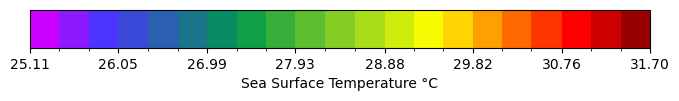

In [61]:
#Make colorbar
vmax = float('-inf')
vmin = float('inf')
for y in range(1985,2023+1):
    print(y)
    df = pd.read_pickle("./CRW/pkl/"+str(y)+".pkl")
    df = df.rename(columns={"CRW_SST": "sst"})
    coordinates = df[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()
    coordinates = palau_eez(df)
    
    vmin_sub   = min(coordinates.sst.tolist())
    vmax_sub   = max(coordinates.sst.tolist())
    vmin = min(vmin_sub,vmin)
    vmax = max(vmax_sub,vmax)
colorbar_mpl_manual_extremes(vmin, vmax, './CRW/weekly/colorbar/CRWfullcolorbar.png')

In [70]:
vmin

25.11

In [71]:
vmax

31.7

In [87]:
import math

In [3]:
boundary = gpd.read_file('palauEEZ.geojson')
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

def getGridGeoJSON_time(time,df):
    df_slice = df[df['time'] == time]


    coordinates = df_slice[['latitude','longitude','sst']]
    coordinates = coordinates.drop_duplicates()

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()
    levels = len(colors)
    vmin   = 25.11
    vmax   = 31.7
    tiers = np.linspace(vmin,vmax,levels+1).tolist()

    
    df_slice = df_slice.sort_values(by=['longitude','latitude'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.latitude, df_slice.longitude))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    for point in points_gdf.geometry:
        if eez.contains(point) or point.within(eez):
            in_palau.append(point)
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["longitude"] = longitude
    voronoi_poly["latitude"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['longitude','latitude'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    values = df_slice['sst'].tolist()
    
    df_colors = []

    for v in values:
        for i in range(len(tiers)):
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break
            if math.isnan(v):
                df_colors.append("#ffffff00")
                break

    
    
    df_slice['fill'] = df_colors

    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
    points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    trimmed['time'] = trimmed['time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

    json_gdf = trimmed.to_json()
    
    return json.loads(json_gdf)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_1733/2239339912.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_1733/2239339912.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [ ]:
for y in range(1985,2023+1):
    df = pd.read_pickle("./CRW/weekly/pkl/"+str(y)+".pkl")
    times = df['time']
    times = list(times.unique())
    df = df.rename(columns={"CRW_SST": "sst"})
    df = df[['time','latitude','longitude','sst']]
    df = palau_eez(df)
    for x in sorted(set(times)):
        geojson_dir = geojson_folder + "CFS" + str(x) +".json"
        currgeo = getGridGeoJSON_time(x,df)
        json_object = json.dumps(currgeo, indent=4)
        
        with open(geojson_dir, "w") as outfile:
            outfile.write(json_object)
            print(geojson_dir)

In [6]:
for y in range(1985,2023+1):
    if y < 2010:
        continue
    df = pd.read_pickle("./CRW/weekly/pkl/"+str(y)+".pkl")
    times = df['time']
    times = list(times.unique())
    df = df.rename(columns={"CRW_SST": "sst"})
    df = df[['time','latitude','longitude','sst']]
    df = palau_eez(df)
    for x in sorted(set(times)):
        geojson_dir = geojson_folder + "CFS" + str(x) +".json"
        
        if "CFS" + str(x) +".json" in os.listdir(geojson_dir):
            continue
        currgeo = getGridGeoJSON_time(x,df)
        json_object = json.dumps(currgeo, indent=4)
        
        with open(geojson_dir, "w") as outfile:
            outfile.write(json_object)
            print(geojson_dir)

NameError: name 'geojson_folder' is not defined